In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import copy
import os
import random
import math as math
import matplotlib.pylab as plt #Typically matplotlib.pylab is imported as plt (shortened name)
import pdb
from scipy.optimize import minimize
import shutil
import csv
from MyLatexFunctions_SocialLearning import * 
from itertools import permutations 
from itertools import combinations
import csv


import networkx as nx

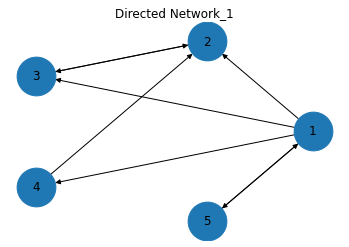

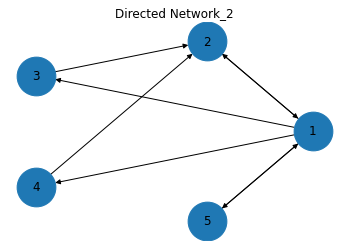

In [2]:
network = ["c1","c2"]
Alldata =  pd.DataFrame()
for i in range(1,3):
    data = pd.read_csv("..\\ImportedData\\network_c"+str(i)+".csv", sep=",", header=0)
    #data.columns = [ "from", "to" ]
    data["network"] = i
    Alldata = Alldata.append(data)

    
for i in range(1,3):
    # Build your graph. Note that we use the DiGraph function to create the graph!
    G=nx.from_pandas_edgelist(Alldata[Alldata.network==i], 'from', 'to', create_using=nx.DiGraph() )

    # Make the graph
    f1 = plt.figure()
    plt.title("Directed Network_"+str(i))
    nx.draw(G, pos=nx.circular_layout(G), with_labels=True, node_size=1500, alpha=1, arrows=True) 
    plt.show()

# Content

- [Sequential Probability](#First-method:-sequantial-probability)

- [Normal Form](#Method-2:-Agent-Normal-Form-Estimation)
    - [Obtain QRE and QRE Figures](#Obtain-QRE-and-QRE-Figures)
    - [ Estimate lambda](#Estimate-lambda)

- [Extensive Form](#Method-3:-Agent-Extensive-Form-Estimation)
    - [ Estimate lambda extensive](#Estimate-lambda-extensive)
    
- [Extensive Form (linear)](#Method-4:-Agent-Extensive-Form-Estimation-linear)

# First method: sequantial probability

- [Return](#Content)

First determine the equilibrium at turn 0, since what matters are only A and B's decision probability, once an equilibrium is achieved, can just add the rest of the probabilities in (For node C, D, E) 

At turn 1, conditional on A and B's decision in turn 1,the payoffs could be different for subjects at different nodes. However, in all cases, the payoff should be fixed and there should be no more strategic consideration.

For example, at turn 1, B will know whether A has made a prediction or not. There are 4 cases: AB both decided, A decidedBnot; ... At turn 2, there are more conditions, but no longer has a strategic consideration in it. But the issue is to assure a subject to make a decision at period 4, for example, the likelihood will be (1-p_i0)*(1-p_i1)*(1-p_i2)*p_i3. It may introduce additional problem at the empirical estimation stage. 

On the other hand if we consider probability at the normal game form, assigning the probabilities as the probability to decide at turn 0,1,2,3,4,5, then my biggest concern is that the decision process doesn't follow what is described in the procedure where a max of future payoffs is considered in the paper and it only considers the probability distribution at turn 0, ignoring the potential information gain from turn 1 and on, when certain information set is not reached or ignore the information updates, but it should give me an underestimated lambda (maybe, or since the method is consistently estimating everything in the expected value term, it is fine/still comparable)

Based on my current reading of the QRE book, the above two methods separately correspond to agent normal-form and agent behavioral strategy method. If you can implement both, maybe worth checking the difference? 

Next step: it is easier to implement the second method (normal form, especially for the latter estimation part) , do that first, after that, can move on to implementing the first method. 

## Incomplete for now since it only considers the strategic interaction between A and B at turn 0, ignoring other nodes and other turns. 

In [4]:
# Network A, payoff for turn 0

# Define the payoff, assuming that the utility depends solely on the payoff
# Estimate the prob of decising at turn 0, 
# Here only focus on A and B
# pOther = [A, B< C, D, E] probability of deciding at turn 0
# pay has two values, [0] is to decide; [1] is to wait for longer
def payoff(pOther,network, cost):
    '''This is for network (a)'''
    diff_pay = 100
    q = 0.7
    if cost=='h':
        c = 8
    elif cost == 'l':
        c = 1
    
    if network == 'a':
        #In network a, I only consider the pay for A and B, at turn 0 
        pay =  np.empty((5,2),dtype=float)
        pay[:,0] = ProbCorrect_Bayesian(1,q)*diff_pay
        # indegree = 1, node A or E, (position 0, 4)
        pay_1 = ProbCorrect_Bayesian(2,q)*diff_pay - c
        pay[0,1] = pay_1 
        pay[4,1] = pay_1 
        # indegree = 1, node D, (position 3)
        pay_2 = pOther[0]*ProbCorrect_Bayesian(2,q)*diff_pay + (1- pOther[0])*ProbCorrect_Bayesian(3,q)*diff_pay - 2*c
        pay[3,1] = max(pay_1, pay_2)
        # indegree = 3, node B
        pay_1 = ProbCorrect_Bayesian(4,q)*diff_pay - c
        pay_2 = pOther[0]*ProbCorrect_Bayesian(4,q)*diff_pay + (1- pOther[0])*ProbCorrect_Bayesian(5,q)*diff_pay - 2*c
        pay[1,1] = max(pay_1, pay_2)
        # indegree = 2, node C
        pay_1 = ProbCorrect_Bayesian(3,q)*diff_pay - c
        pay_2 = pOther[0]*pOther[1]*ProbCorrect_Bayesian(3,q)*diff_pay 
        + (pOther[1]*(1- pOther[0])+pOther[0]*(1- pOther[1]))*ProbCorrect_Bayesian(4,q)*diff_pay + (1-pOther[0])*(1-pOther[1])*ProbCorrect_Bayesian(3,q)*diff_pay - 2*c
        pay[2,1] = max(pay_1, pay_2)
        
    if network == 'b':
         # We know there are 5 nodes, pay matrix is 5X6 ( 6 period)
        pay =  np.empty((5,2),dtype=float)
        pay[:,0] = ProbCorrect_Bayesian(1,q)*diff_pay

        # Note: since here the payoff is about turn 0,1,2, need to do the max in the 
        # indegree = 2, node A
        pay_1 = pOther[1]* (ProbCorrect_Bayesian(3,q)*diff_pay - c) + (1-pOther[1])* np.max([ProbCorrect_Bayesian(5,q)*diff_pay-2*c, ProbCorrect_Bayesian(3,q)*diff_pay-c])
        pay[0,1] = pay_1
        
        # indegree = 3, node B
        pay_1 =  pOther[0]* (ProbCorrect_Bayesian(4,q)*diff_pay - c) + (1- pOther[0])*np.max([ProbCorrect_Bayesian(4,q)*diff_pay - c,ProbCorrect_Bayesian(5,q)*diff_pay - 2*c])
        pay[1,1] = pay_1
        
        #indegree = 1, node C/D/E; not relevant for QRE calculation, but will change based on later decisions
        pay_1 = pOther[0]*(ProbCorrect_Bayesian(2,q)*diff_pay - c) + (1-pOther[0])*pOther[1]*(ProbCorrect_Bayesian(3,q)*diff_pay - 2*c)  + (1-pOther[0])*(1-pOther[1])*(ProbCorrect_Bayesian(5,q)*diff_pay - 3*c) 
        pay[2:5,1] = pay_1

    return pay
    
    


In [5]:
payoff([0.1,0.1],'b','l') # payoff for nodes A, B,-E decide vs wait at turn 0


array([[70.     , 81.2628 ],
       [70.     , 81.2628 ],
       [70.     , 79.13652],
       [70.     , 79.13652],
       [70.     , 79.13652]])

In [6]:
# Note: My payoff_a has considered the pOthers, the probability of others
## Iteration process

def policy_iter(l,p_ini,network, waitingcost, tol = 1e-10):
    
    error = 1
    p_1 = np.array(p_ini)
    p_2 = np.array(p_ini)
    
    nrep = 1
    while error > tol:
        pOthers = np.array([p_1[0], p_2[0]])
        mixed_payoff_1 = payoff(pOthers,network, waitingcost)[0] # why I should use p_1? 
        mixed_payoff_2 = payoff(pOthers,network, waitingcost)[1] 
        print(mixed_payoff_1)
        sigma_1 = np.exp(l*mixed_payoff_1)/np.sum(np.exp(l*mixed_payoff_1))
        sigma_2 = np.exp(l*mixed_payoff_2)/np.sum(np.exp(l*mixed_payoff_2))
        error_1 = np.sum(np.abs(sigma_1-p_1))
        error_2 = np.sum(np.abs(sigma_2-p_2))
        
        error = max(error_1,error_2)
#         print("Minimum error", error)
        
        p_1 = sigma_1
        p_2 = sigma_2
        nrep += 1
        
    print("Number of Iterations:",nrep)
    return [p_1,p_2]
        

Round: 1
[70. 69.]
Number of Iterations: 2
Round: 2
[70. 69.]
[70. 69.]
[70. 69.]
Number of Iterations: 4
Round: 3
[70. 69.]
[70. 69.]
[70. 69.]
Number of Iterations: 4
Round: 4
[70. 69.]
[70. 69.]
[70. 69.]
Number of Iterations: 4
Round: 5
[70. 69.]
[70. 69.]
[70. 69.]
Number of Iterations: 4
Round: 6
[70. 69.]
[70. 69.]
[70. 69.]
Number of Iterations: 4
Round: 7
[70. 69.]
[70. 69.]
[70. 69.]
Number of Iterations: 4
Round: 8
[70. 69.]
[70. 69.]
[70. 69.]
Number of Iterations: 4
Round: 9
[70. 69.]
[70. 69.]
[70. 69.]
Number of Iterations: 4
Round: 10
[70. 69.]
[70. 69.]
[70. 69.]
Number of Iterations: 4
Round: 11
[70. 69.]
[70. 69.]
[70. 69.]
Number of Iterations: 4
Round: 12
[70. 69.]
[70. 69.]
[70. 69.]
Number of Iterations: 4
Round: 13
[70. 69.]
[70. 69.]
[70. 69.]
Number of Iterations: 4
Round: 14
[70. 69.]
[70. 69.]
[70. 69.]
Number of Iterations: 4
Round: 15
[70. 69.]
[70. 69.]
[70. 69.]
Number of Iterations: 4
Round: 16
[70. 69.]
[70. 69.]
[70. 69.]
Number of Iterations: 4
Round

C:\Users\xinxi\AppData\Local\Temp/ipykernel_8056/3109127715.py:17: RuntimeWarning: overflow encountered in exp
  sigma_2 = np.exp(l*mixed_payoff_2)/np.sum(np.exp(l*mixed_payoff_2))
C:\Users\xinxi\AppData\Local\Temp/ipykernel_8056/3109127715.py:17: RuntimeWarning: invalid value encountered in true_divide
  sigma_2 = np.exp(l*mixed_payoff_2)/np.sum(np.exp(l*mixed_payoff_2))
C:\Users\xinxi\AppData\Local\Temp/ipykernel_8056/3109127715.py:16: RuntimeWarning: overflow encountered in exp
  sigma_1 = np.exp(l*mixed_payoff_1)/np.sum(np.exp(l*mixed_payoff_1))
C:\Users\xinxi\AppData\Local\Temp/ipykernel_8056/3109127715.py:16: RuntimeWarning: invalid value encountered in true_divide
  sigma_1 = np.exp(l*mixed_payoff_1)/np.sum(np.exp(l*mixed_payoff_1))
C:\Users\xinxi\AppData\Local\Temp/ipykernel_8056/2405291984.py:34: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  lgd = ax.legend(handles, labels = labels, loc = 0)



[70. 69.]
Number of Iterations: 2
Round: 177
[70. 69.]
Number of Iterations: 2
Round: 178
[70. 69.]
Number of Iterations: 2
Round: 179
[70. 69.]
Number of Iterations: 2
Round: 180
[70. 69.]
Number of Iterations: 2
Round: 181
[70. 69.]
Number of Iterations: 2
Round: 182
[70. 69.]
Number of Iterations: 2
Round: 183
[70. 69.]
Number of Iterations: 2
Round: 184
[70. 69.]
Number of Iterations: 2
Round: 185
[70. 69.]
Number of Iterations: 2
Round: 186
[70. 69.]
Number of Iterations: 2
Round: 187
[70. 69.]
Number of Iterations: 2
Round: 188
[70. 69.]
Number of Iterations: 2
Round: 189
[70. 69.]
Number of Iterations: 2
Round: 190
[70. 69.]
Number of Iterations: 2
Round: 191
[70. 69.]
Number of Iterations: 2
Round: 192
[70. 69.]
Number of Iterations: 2
Round: 193
[70. 69.]
Number of Iterations: 2
Round: 194
[70. 69.]
Number of Iterations: 2
Round: 195
[70. 69.]
Number of Iterations: 2
Round: 196
[70. 69.]
Number of Iterations: 2
Round: 197
[70. 69.]
Number of Iterations: 2
Round: 198
[70. 69.]

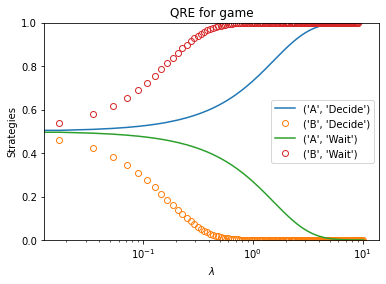

In [7]:
lambd = []
n = 200
for i in range(n):
    lambd.append(1.0173182**i - 1)

p_1 = np.empty((n,2))
p_2 = np.empty((n,2))

for i in range(n):
    print("Round:", i+1)
    Result = policy_iter(lambd[i],[1/2,1/2],'a','l')
    p_1[i] = Result[0]
    p_2[i] = Result[1]
    
fig, ax = plt.subplots()
ax.set_xlabel('$\lambda$')
ax.set_ylabel('Strategies')
handles, labels = ax.get_legend_handles_labels()
ax.set_title("QRE for game")
ax.set_ylim(0, 1)
ax.set_xscale('log')
Strategy_names_1 = ['Decide', 'Wait']
Strategy_names_2 = ['Decide', 'Wait']

# Symmetric Case:

for i in range(2):
    
    ax.plot(lambd,p_1[:,i])
    ax.plot(lambd,p_2[:,i],'o',markerfacecolor = "none")
    labels.append(('A', Strategy_names_1[i]))
    labels.append(('B', Strategy_names_2[i]))

lgd = ax.legend(handles, labels = labels, loc = 0)         

In [8]:
p_1

array([[5.00000000e-01, 5.00000000e-01],
       [5.04329442e-01, 4.95670558e-01],
       [5.08733192e-01, 4.91266808e-01],
       [5.13211812e-01, 4.86788188e-01],
       [5.17765815e-01, 4.82234185e-01],
       [5.22395653e-01, 4.77604347e-01],
       [5.27101722e-01, 4.72898278e-01],
       [5.31884349e-01, 4.68115651e-01],
       [5.36743794e-01, 4.63256206e-01],
       [5.41680240e-01, 4.58319760e-01],
       [5.46693788e-01, 4.53306212e-01],
       [5.51784454e-01, 4.48215546e-01],
       [5.56952163e-01, 4.43047837e-01],
       [5.62196742e-01, 4.37803258e-01],
       [5.67517914e-01, 4.32482086e-01],
       [5.72915294e-01, 4.27084706e-01],
       [5.78388381e-01, 4.21611619e-01],
       [5.83936552e-01, 4.16063448e-01],
       [5.89559058e-01, 4.10440942e-01],
       [5.95255016e-01, 4.04744984e-01],
       [6.01023402e-01, 3.98976598e-01],
       [6.06863048e-01, 3.93136952e-01],
       [6.12772633e-01, 3.87227367e-01],
       [6.18750680e-01, 3.81249320e-01],
       [6.247955

Round: 1
[70. 62.]
Number of Iterations: 2
Round: 2
[70. 62.]
[70. 62.]
Number of Iterations: 3
Round: 3
[70. 62.]
[70. 62.]
Number of Iterations: 3
Round: 4
[70. 62.]
[70. 62.]
Number of Iterations: 3
Round: 5
[70. 62.]
[70. 62.]
Number of Iterations: 3
Round: 6
[70. 62.]
[70. 62.]
Number of Iterations: 3
Round: 7
[70. 62.]
[70. 62.]
Number of Iterations: 3
Round: 8
[70. 62.]
[70. 62.]
Number of Iterations: 3
Round: 9
[70. 62.]
[70. 62.]
Number of Iterations: 3
Round: 10
[70. 62.]
[70. 62.]
Number of Iterations: 3
Round: 11
[70. 62.]
[70. 62.]
Number of Iterations: 3
Round: 12
[70. 62.]
[70. 62.]
Number of Iterations: 3
Round: 13
[70. 62.]
[70. 62.]
Number of Iterations: 3
Round: 14
[70. 62.]
[70. 62.]
Number of Iterations: 3
Round: 15
[70. 62.]
[70. 62.]
Number of Iterations: 3
Round: 16
[70. 62.]
[70. 62.]
Number of Iterations: 3
Round: 17
[70. 62.]
[70. 62.]
Number of Iterations: 3
Round: 18
[70. 62.]
[70. 62.]
Number of Iterations: 3
Round: 19
[70. 62.]
[70. 62.]
Number of Iterati

C:\Users\xinxi\AppData\Local\Temp/ipykernel_8056/3109127715.py:16: RuntimeWarning: overflow encountered in exp
  sigma_1 = np.exp(l*mixed_payoff_1)/np.sum(np.exp(l*mixed_payoff_1))
C:\Users\xinxi\AppData\Local\Temp/ipykernel_8056/3109127715.py:16: RuntimeWarning: invalid value encountered in true_divide
  sigma_1 = np.exp(l*mixed_payoff_1)/np.sum(np.exp(l*mixed_payoff_1))
C:\Users\xinxi\AppData\Local\Temp/ipykernel_8056/3109127715.py:17: RuntimeWarning: overflow encountered in exp
  sigma_2 = np.exp(l*mixed_payoff_2)/np.sum(np.exp(l*mixed_payoff_2))
C:\Users\xinxi\AppData\Local\Temp/ipykernel_8056/3109127715.py:17: RuntimeWarning: invalid value encountered in true_divide
  sigma_2 = np.exp(l*mixed_payoff_2)/np.sum(np.exp(l*mixed_payoff_2))
C:\Users\xinxi\AppData\Local\Temp/ipykernel_8056/1600054940.py:34: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  lgd = ax.legend(handles, labels = labels, loc = 0)



Number of Iterations: 2
Round: 188
[70. 62.]
Number of Iterations: 2
Round: 189
[70. 62.]
Number of Iterations: 2
Round: 190
[70. 62.]
Number of Iterations: 2
Round: 191
[70. 62.]
Number of Iterations: 2
Round: 192
[70. 62.]
Number of Iterations: 2
Round: 193
[70. 62.]
Number of Iterations: 2
Round: 194
[70. 62.]
Number of Iterations: 2
Round: 195
[70. 62.]
Number of Iterations: 2
Round: 196
[70. 62.]
Number of Iterations: 2
Round: 197
[70. 62.]
Number of Iterations: 2
Round: 198
[70. 62.]
Number of Iterations: 2
Round: 199
[70. 62.]
Number of Iterations: 2
Round: 200
[70. 62.]
Number of Iterations: 2


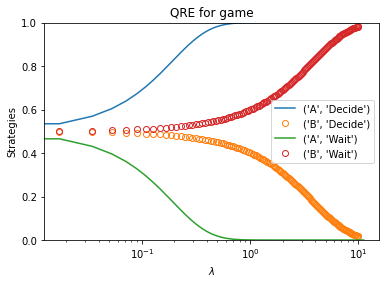

In [9]:
lambd = []
n = 200
for i in range(n):
    lambd.append(1.0173182**i - 1)

p_1 = np.empty((n,2))
p_2 = np.empty((n,2))

for i in range(n):
    print("Round:", i+1)
    Result = policy_iter(lambd[i],[1/2,1/2],'a','h')
    p_1[i] = Result[0]
    p_2[i] = Result[1]
    
fig, ax = plt.subplots()
ax.set_xlabel('$\lambda$')
ax.set_ylabel('Strategies')
handles, labels = ax.get_legend_handles_labels()
ax.set_title("QRE for game")
ax.set_ylim(0, 1)
ax.set_xscale('log')
Strategy_names_1 = ['Decide', 'Wait']
Strategy_names_2 = ['Decide', 'Wait']

# Symmetric Case:

for i in range(2):
    
    ax.plot(lambd,p_1[:,i])
    ax.plot(lambd,p_2[:,i],'o',markerfacecolor = "none")
    labels.append(('A', Strategy_names_1[i]))
    labels.append(('B', Strategy_names_2[i]))

lgd = ax.legend(handles, labels = labels, loc = 0)         

Round: 1
[70.    79.546]
Number of Iterations: 2
Round: 2
[70.    79.546]
[70.         79.72298496]
[70.         79.72625098]
[70.         79.72631124]
[70.         79.72631236]
[70.         79.72631238]
[70.         79.72631238]
Number of Iterations: 8
Round: 3
[70.    79.546]
[70.         79.90056748]
[70.         79.91348282]
[70.         79.91395276]
[70.         79.91396985]
[70.         79.91397048]
[70.        79.9139705]
[70.        79.9139705]
Number of Iterations: 9
Round: 4
[70.    79.546]
[70.         80.07622984]
[70.         80.10436837]
[70.         80.10585601]
[70.         80.10593464]
[70.        80.1059388]
[70.         80.10593902]
[70.         80.10593903]
[70.         80.10593903]
Number of Iterations: 10
Round: 5
[70.    79.546]
[70.         80.24747833]
[70.         80.29487548]
[70.         80.29804892]
[70.         80.29826126]
[70.         80.29827547]
[70.         80.29827642]
[70.         80.29827648]
[70.         80.29827648]
[70.         80.29827648]
Numb

[70.    79.546]
[70.    81.692]
Number of Iterations: 3
Round: 121
[70.    79.546]
[70.    81.692]
Number of Iterations: 3
Round: 122
[70.    79.546]
[70.    81.692]
Number of Iterations: 3
Round: 123
[70.    79.546]
[70.    81.692]
Number of Iterations: 3
Round: 124
[70.    79.546]
[70.    81.692]
Number of Iterations: 3
Round: 125
[70.    79.546]
[70.    81.692]
Number of Iterations: 3
Round: 126
[70.    79.546]
[70.    81.692]
Number of Iterations: 3
Round: 127
[70.    79.546]
[70.    81.692]
Number of Iterations: 3
Round: 128
[70.    79.546]
[70.    81.692]
Number of Iterations: 3
Round: 129
[70.    79.546]
[70.    81.692]
Number of Iterations: 3
Round: 130
[70.    79.546]
[70.    81.692]
Number of Iterations: 3
Round: 131
[70.    79.546]
[70.    81.692]
Number of Iterations: 3
Round: 132
[70.    79.546]
[70.    81.692]
Number of Iterations: 3
Round: 133
[70.    79.546]
[70.    81.692]
Number of Iterations: 3
Round: 134
[70.    79.546]
[70.    81.692]
Number of Iterations: 3
Round:

C:\Users\xinxi\AppData\Local\Temp/ipykernel_8056/3109127715.py:16: RuntimeWarning: overflow encountered in exp
  sigma_1 = np.exp(l*mixed_payoff_1)/np.sum(np.exp(l*mixed_payoff_1))
C:\Users\xinxi\AppData\Local\Temp/ipykernel_8056/3109127715.py:16: RuntimeWarning: invalid value encountered in true_divide
  sigma_1 = np.exp(l*mixed_payoff_1)/np.sum(np.exp(l*mixed_payoff_1))
C:\Users\xinxi\AppData\Local\Temp/ipykernel_8056/3109127715.py:17: RuntimeWarning: overflow encountered in exp
  sigma_2 = np.exp(l*mixed_payoff_2)/np.sum(np.exp(l*mixed_payoff_2))
C:\Users\xinxi\AppData\Local\Temp/ipykernel_8056/3109127715.py:17: RuntimeWarning: invalid value encountered in true_divide
  sigma_2 = np.exp(l*mixed_payoff_2)/np.sum(np.exp(l*mixed_payoff_2))
C:\Users\xinxi\AppData\Local\Temp/ipykernel_8056/699999969.py:34: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  lgd = ax.legend(handles, labels = labels, loc = 0)


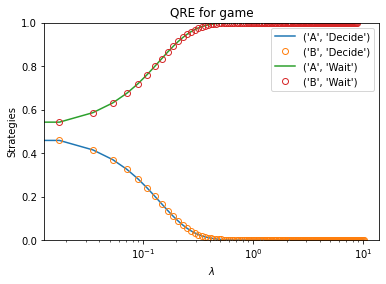

In [10]:
lambd = []
n = 200
for i in range(n):
    lambd.append(1.0173182**i - 1)

p_1 = np.empty((n,2))
p_2 = np.empty((n,2))

for i in range(n):
    print("Round:", i+1)
    Result = policy_iter(lambd[i],[1/2,1/2],'b','l')
    p_1[i] = Result[0]
    p_2[i] = Result[1]
    
fig, ax = plt.subplots()
ax.set_xlabel('$\lambda$')
ax.set_ylabel('Strategies')
handles, labels = ax.get_legend_handles_labels()
ax.set_title("QRE for game")
ax.set_ylim(0, 1)
ax.set_xscale('log')
Strategy_names_1 = ['Decide', 'Wait']
Strategy_names_2 = ['Decide', 'Wait']

# Symmetric Case:

for i in range(2):
    
    ax.plot(lambd,p_1[:,i])
    ax.plot(lambd,p_2[:,i],'o',markerfacecolor = "none")
    labels.append(('A', Strategy_names_1[i]))
    labels.append(('B', Strategy_names_2[i]))

lgd = ax.legend(handles, labels = labels, loc = 0)         

Round: 1
[70.  70.4]
Number of Iterations: 2
Round: 2
[70.  70.4]
[70.  70.4]
Number of Iterations: 3
Round: 3
[70.  70.4]
[70.  70.4]
Number of Iterations: 3
Round: 4
[70.  70.4]
[70.  70.4]
Number of Iterations: 3
Round: 5
[70.  70.4]
[70.  70.4]
Number of Iterations: 3
Round: 6
[70.  70.4]
[70.  70.4]
Number of Iterations: 3
Round: 7
[70.  70.4]
[70.  70.4]
Number of Iterations: 3
Round: 8
[70.  70.4]
[70.  70.4]
Number of Iterations: 3
Round: 9
[70.  70.4]
[70.  70.4]
Number of Iterations: 3
Round: 10
[70.  70.4]
[70.  70.4]
Number of Iterations: 3
Round: 11
[70.  70.4]
[70.  70.4]
Number of Iterations: 3
Round: 12
[70.  70.4]
[70.  70.4]
Number of Iterations: 3
Round: 13
[70.  70.4]
[70.  70.4]
Number of Iterations: 3
Round: 14
[70.  70.4]
[70.  70.4]
Number of Iterations: 3
Round: 15
[70.  70.4]
[70.  70.4]
Number of Iterations: 3
Round: 16
[70.  70.4]
[70.  70.4]
Number of Iterations: 3
Round: 17
[70.  70.4]
[70.  70.4]
Number of Iterations: 3
Round: 18
[70.  70.4]
[70.  70.4]
N

C:\Users\xinxi\AppData\Local\Temp/ipykernel_17672/3109127715.py:16: RuntimeWarning: overflow encountered in exp
  sigma_1 = np.exp(l*mixed_payoff_1)/np.sum(np.exp(l*mixed_payoff_1))
C:\Users\xinxi\AppData\Local\Temp/ipykernel_17672/3109127715.py:16: RuntimeWarning: invalid value encountered in true_divide
  sigma_1 = np.exp(l*mixed_payoff_1)/np.sum(np.exp(l*mixed_payoff_1))
C:\Users\xinxi\AppData\Local\Temp/ipykernel_17672/3109127715.py:17: RuntimeWarning: overflow encountered in exp
  sigma_2 = np.exp(l*mixed_payoff_2)/np.sum(np.exp(l*mixed_payoff_2))
C:\Users\xinxi\AppData\Local\Temp/ipykernel_17672/3109127715.py:17: RuntimeWarning: invalid value encountered in true_divide
  sigma_2 = np.exp(l*mixed_payoff_2)/np.sum(np.exp(l*mixed_payoff_2))
C:\Users\xinxi\AppData\Local\Temp/ipykernel_17672/1953066089.py:34: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  lgd = ax.legend(handles, labels = labels, loc = 0)


187
[70.  70.4]
Number of Iterations: 2
Round: 188
[70.  70.4]
Number of Iterations: 2
Round: 189
[70.  70.4]
Number of Iterations: 2
Round: 190
[70.  70.4]
Number of Iterations: 2
Round: 191
[70.  70.4]
Number of Iterations: 2
Round: 192
[70.  70.4]
Number of Iterations: 2
Round: 193
[70.  70.4]
Number of Iterations: 2
Round: 194
[70.  70.4]
Number of Iterations: 2
Round: 195
[70.  70.4]
Number of Iterations: 2
Round: 196
[70.  70.4]
Number of Iterations: 2
Round: 197
[70.  70.4]
Number of Iterations: 2
Round: 198
[70.  70.4]
Number of Iterations: 2
Round: 199
[70.  70.4]
Number of Iterations: 2
Round: 200
[70.  70.4]
Number of Iterations: 2


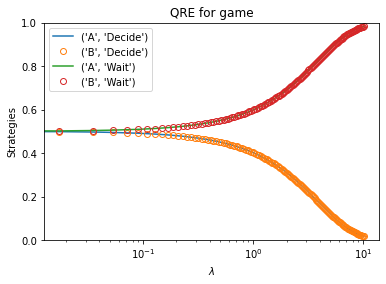

In [10]:
lambd = []
n = 200
for i in range(n):
    lambd.append(1.0173182**i - 1)

p_1 = np.empty((n,2))
p_2 = np.empty((n,2))

for i in range(n):
    print("Round:", i+1)
    Result = policy_iter(lambd[i],[1/2,1/2],'b','h')
    p_1[i] = Result[0]
    p_2[i] = Result[1]
    
fig, ax = plt.subplots()
ax.set_xlabel('$\lambda$')
ax.set_ylabel('Strategies')
handles, labels = ax.get_legend_handles_labels()
ax.set_title("QRE for game")
ax.set_ylim(0, 1)
ax.set_xscale('log')
Strategy_names_1 = ['Decide', 'Wait']
Strategy_names_2 = ['Decide', 'Wait']

# Symmetric Case:

for i in range(2):
    
    ax.plot(lambd,p_1[:,i])
    ax.plot(lambd,p_2[:,i],'o',markerfacecolor = "none")
    labels.append(('A', Strategy_names_1[i]))
    labels.append(('B', Strategy_names_2[i]))

lgd = ax.legend(handles, labels = labels, loc = 0)         

# Method 2: Agent Normal Form Estimation

- [Return](#Content)

Probability is defined as a matrix of 5*6 (5 nodes, deciding at 6 turns). It is assumed that each subject with a given lambda will pre-determine the probability of makig a prediction at a certain turn, the probability doesn't change based on what new information is updated as time goes by (Not sure what is a more formal/proper way to describe this)


Comment: Got very interesting results!!!

The normal form equilibrium is not the bayesian perfect nash equilibrium ... (Maybe because how we use the max to derive the optimal rule...)

NOTE: NETWORK B EXPECTED PAYOFF UPDATED ONLY FROM HERE!!!!

In [3]:
# Step 1: Define Payoffs for Deciding at each turn; The payoff depends on others' probability of making a prediction 

# Step 2: Write out the policy iteration 

# Step 3: for different lambda value, derive the results

# Step 4: Based on the estimation result, do two things 
# A. Draw QRE for each node for each treatment, show the difference, describe
# B. Estimate MLE based on realized/observed frequencies in each treatment


In [173]:
#Step 1. 
def payoff(pOther,network, cost):
    '''This is for the normal form estimation 
        pOther = matrix(5,6); each row is for each node; each column is for each turn
        '''
    diff_pay = 100
    q = 0.7
    if cost=='h':
        c = 8
    elif cost == 'l':
        c = 1
    
    if network == 'a':
        #In network a, I only consider the pay for A and B, at turn 0 
        pay =  np.empty((5,6),dtype=float)
        pay[:,0] = ProbCorrect_Bayesian(1,q)*diff_pay
        
        # indegree = 1, node A / E
        pay_1 = ProbCorrect_Bayesian(2,q)*diff_pay - c
        pay[0,1] = pay_1 
        pay[4,1] = pay_1 
        j = 2
        while j <= 5:        
            pay[0,j] = ProbCorrect_Bayesian(2,q)*diff_pay - j*c
            pay[4,j] = ProbCorrect_Bayesian(2,q)*diff_pay - j*c
            j += 1
        
        # indegree = 3, node B
        pay_1 = ProbCorrect_Bayesian(4,q)*diff_pay - c
        pi_b = pOther[0,0]*ProbCorrect_Bayesian(4,q)*diff_pay + (1- pOther[0,0])*ProbCorrect_Bayesian(5,q)*diff_pay 
        pay[1,1] = pay_1
        j = 2
        while j <= 5:        
            pay[1,j] = pi_b - j*c
            j += 1

        # indegree = 2, node C
        pay_1 = ProbCorrect_Bayesian(3,q)*diff_pay - c
        pay[2,1] = pay_1
        pi_c = pOther[0, 0]*pOther[1,0]*ProbCorrect_Bayesian(3,q)*diff_pay + ((1-pOther[0, 0])*pOther[1,0] + pOther[0, 0]*(1-pOther[1,0]))*ProbCorrect_Bayesian(4,q)*diff_pay + (1-pOther[0, 0])*(1-pOther[1,0])*ProbCorrect_Bayesian(3,q)*diff_pay
        j = 2
        while j <= 5:        
            pay[2,j] = pi_c - j*c
            j += 1
            
        # indegree = 1, node D (position 3)
        pay_1 = ProbCorrect_Bayesian(2,q)*diff_pay - c
        pay[3,1] = pay_1 
        pi_d = pOther[0,0]*ProbCorrect_Bayesian(2,q)*diff_pay + (1- pOther[0,0])*ProbCorrect_Bayesian(3,q)*diff_pay 
        j = 2
        while j <= 5:        
            pay[3,j] = pi_d - j*c
            j += 1
        
   
        
    elif network == 'b':
         # We know there are 5 nodes, pay matrix is 5X6 ( 6 period)
        pay =  np.empty((5,6),dtype=float)
        pay[:,0] = ProbCorrect_Bayesian(1,q)*diff_pay

        # Note: since here the payoff is about turn 0,1,2, need to do the max in the 
        # indegree = 2, node A
        pay_1 = ProbCorrect_Bayesian(3,q)*diff_pay - c
        pi_a = pOther[1,0]*ProbCorrect_Bayesian(3,q)*diff_pay + (1-pOther[1,0])*ProbCorrect_Bayesian(5,q)*diff_pay        
        pay[0,1] = pay_1
        j = 2
        while j <= 5:        
            pay[0,j] = pi_a - j*c
            j += 1

        # indegree = 3, node B
        pay_1 = ProbCorrect_Bayesian(4,q)*diff_pay - c
        pi_b = pOther[0,0]*ProbCorrect_Bayesian(4,q)*diff_pay + (1- pOther[0,0])*ProbCorrect_Bayesian(5,q)*diff_pay 
        pay[1,1] = pay_1
        j = 2
        while j <= 5:        
            pay[1,j] = pi_b - j*c
            j += 1


        # indegree = 1, node C or D or E, (position 2,3)
        pay_1 = ProbCorrect_Bayesian(2,q)*diff_pay - c
        pay[2:5,1] = pay_1
        # Since in bayesian updating, having 3 or 4 signals carry the same informaiton value, can group these points together
        pi_e0 =  pOther[0,0]*ProbCorrect_Bayesian(2,q)*diff_pay + (1-pOther[0,0])*ProbCorrect_Bayesian(3,q)*diff_pay 
        pay[2:5,2] = pi_e0 - 2*c
        pi_e =  pOther[0,0]*ProbCorrect_Bayesian(2,q)*diff_pay + (pOther[0,1] + (1- pOther[0,0] -pOther[0,1])*pOther[1,0])*ProbCorrect_Bayesian(3,q)*diff_pay  +(1- pOther[0,0] -pOther[0,1])*(1-pOther[1,0])*ProbCorrect_Bayesian(5,q)*diff_pay 
        
        j = 3
        while j <= 5:        
            pay[2:5,j] = pi_e - j*c
            j += 1
#     pay_avg = np.sum(pay,axis=1)
#     return pay/pay_avg[:,None]
    return pay/70
    

In [174]:
pOthers = np.ones((5,6))* 1/6
network = 'b'
waitingcost = 'l'
x = payoff(pOthers,network, waitingcost)
x

array([[1.        , 1.10571429, 1.15442857, 1.14014286, 1.12585714,
        1.11157143],
       [1.        , 1.10571429, 1.15442857, 1.14014286, 1.12585714,
        1.11157143],
       [1.        , 0.98571429, 1.07142857, 1.09914286, 1.08485714,
        1.07057143],
       [1.        , 0.98571429, 1.07142857, 1.09914286, 1.08485714,
        1.07057143],
       [1.        , 0.98571429, 1.07142857, 1.09914286, 1.08485714,
        1.07057143]])

In [175]:
pOthers = np.ones((5,6))* 1/6
network = 'a'
waitingcost = 'l'
x = payoff(pOthers,network, waitingcost)
x
# node_avg =  np.sum(x,axis=1)
# node_avg

array([[1.        , 0.98571429, 0.97142857, 0.95714286, 0.94285714,
        0.92857143],
       [1.        , 1.10571429, 1.15442857, 1.14014286, 1.12585714,
        1.11157143],
       [1.        , 1.10571429, 1.09142857, 1.07714286, 1.06285714,
        1.04857143],
       [1.        , 0.98571429, 1.07142857, 1.05714286, 1.04285714,
        1.02857143],
       [1.        , 0.98571429, 0.97142857, 0.95714286, 0.94285714,
        0.92857143]])

In [176]:
# Step 2

def policy_iter(l,p_ini,network, waitingcost, tol = 1e-10):
    
    error = 1
    pOthers = np.ones((5,6))* p_ini
    
    nrep = 1
    while error > tol:
        
        mixed_payoff = payoff(pOthers,network, waitingcost)
        add_error = np.exp(l*mixed_payoff)

        node_avg =  np.sum(add_error,axis=1)
        sigma = add_error / node_avg[:,None]

        error = np.max(np.sum(np.abs(sigma-pOthers), axis=1))
        pOthers = sigma

        nrep += 1
        
    print("Number of Iterations:",nrep)
    return pOthers
        

In [177]:
# Step 3
# lambd = []
n = 200
lambd = np.logspace(-1, 2.5, n, endpoint=True)
# for i in range(n):
#     lambd.append(1.0173182**i - 1)

def QRE_Outcome(network, waitingCost):
    '''Contains both the prob and graphs'''
    
    p = np.empty((n,5,6))
    for i in range(n):
#         print("Round:", i+1)
        Result = policy_iter(lambd[i],1/6,network,waitingCost)
        p[i] = Result
    
    

    # By Indegree
    i = 1 # Node B is always the indegree=3
    fig, ax = plt.subplots()
    ax.set_xlabel('$\lambda$')
    ax.set_ylabel('Strategies')
    handles, labels = ax.get_legend_handles_labels()
    ax.set_title("QRE for Nodes with Multiple Information Souces")
    ax.set_ylim(0, 1)
    ax.set_xscale('log')
    for j in range(6):
        ax.plot(lambd,p[:,i,j], label='Turn'+str(j))
    ax.legend()
    fig.savefig("..\\Output_Figures\\05-QRE-Calculation\\"+"QRE"+network+"-"+waitingCost+"-mSource", bbox_inches="tight")  

    i = 3 # Node D is always the indegree=1
    fig, ax = plt.subplots()
    ax.set_xlabel('$\lambda$')
    ax.set_ylabel('Strategies')
    handles, labels = ax.get_legend_handles_labels()
    ax.set_title("QRE for Nodes with Single Information Source")
    ax.set_ylim(0, 1)
    ax.set_xscale('log')
    for j in range(6):
        ax.plot(lambd,p[:,i,j], label='Turn'+str(j))
    ax.legend()
    fig.savefig("..\\Output_Figures\\05-QRE-Calculation\\"+"QRE"+network+"-"+waitingCost+"-sSource", bbox_inches="tight")  

    
    return p
    


## Obtain QRE and QRE Figures

Including empirical data (obtained in the next section)

- [Return](#Content)

Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterat

Number of Iterations: 5
Number of Iterations: 5
Number of Iterations: 5
Number of Iterations: 5
Number of Iterations: 5
Number of Iterations: 5
Number of Iterations: 5
Number of Iterations: 5
Number of Iterations: 5
Number of Iterations: 5
Number of Iterations: 5
Number of Iterations: 5
Number of Iterations: 6
Number of Iterations: 6
Number of Iterations: 6
Number of Iterations: 6
Number of Iterations: 6
Number of Iterations: 6
Number of Iterations: 6
Number of Iterations: 6
Number of Iterations: 6
Number of Iterations: 6
Number of Iterations: 6
Number of Iterations: 6
Number of Iterations: 6
Number of Iterations: 6
Number of Iterations: 6
Number of Iterations: 6
Number of Iterations: 6
Number of Iterations: 6
Number of Iterations: 6
Number of Iterations: 6
Number of Iterations: 6
Number of Iterations: 6
Number of Iterations: 6
Number of Iterations: 6
Number of Iterations: 6
Number of Iterations: 6
Number of Iterations: 6
Number of Iterations: 6
Number of Iterations: 6
Number of Iterat

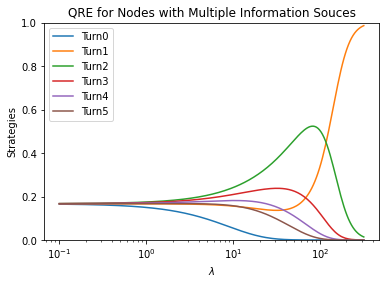

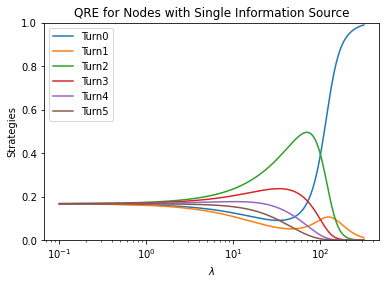

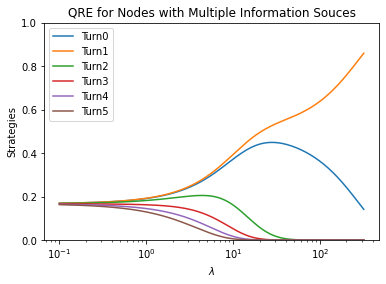

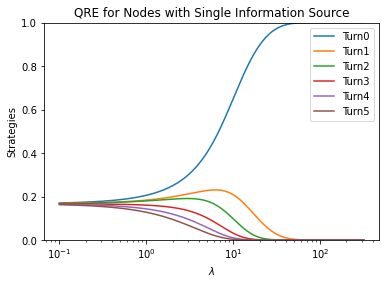

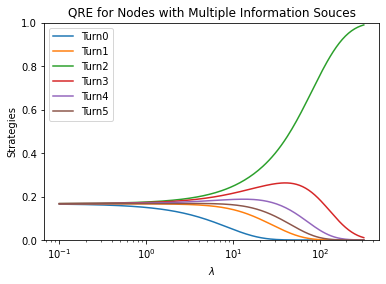

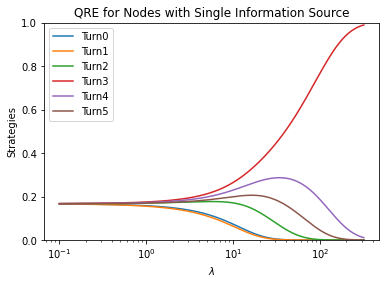

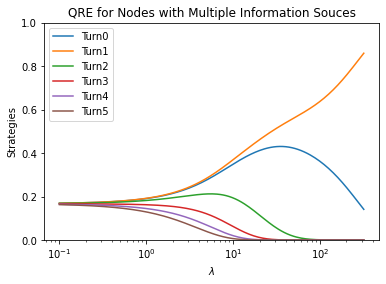

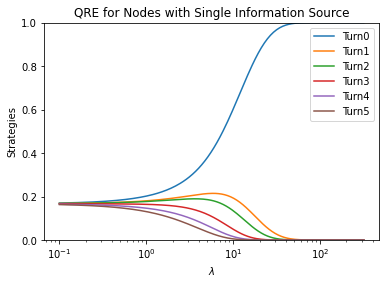

In [178]:
# Obtain the QRE and output QRE figures

QRE_a_l = QRE_Outcome('a', 'l')
QRE_a_h = QRE_Outcome('a', 'h')
QRE_b_l = QRE_Outcome('b', 'l')
QRE_b_h = QRE_Outcome('b', 'h')



In [179]:
avg_turn[t, :,[0,1]].mean(axis=0)
# .mean()

# .mean(axis=(0))
# .mean(axis=1)

array([0.96528167, 0.96513883, 0.96499014, 0.96483534, 0.9646742 ,
       0.96450646, 0.96433184, 0.96415007, 0.96396085, 0.9637639 ,
       0.96355888, 0.96334548, 0.96312335, 0.96289216, 0.96265151,
       0.96240105, 0.96214037, 0.96186906, 0.96158669, 0.96129283,
       0.960987  , 0.96066874, 0.96033754, 0.95999288, 0.95963424,
       0.95926105, 0.95887274, 0.9584687 , 0.95804833, 0.95761096,
       0.95715593, 0.95668254, 0.95619008, 0.9556778 , 0.95514492,
       0.95459064, 0.95401413, 0.95341452, 0.95279093, 0.95214243,
       0.95146807, 0.95076685, 0.95003775, 0.94927971, 0.94849164,
       0.9476724 , 0.94682082, 0.94593571, 0.9450158 , 0.94405982,
       0.94306643, 0.94203427, 0.94096194, 0.93984797, 0.93869088,
       0.93748912, 0.93624113, 0.93494527, 0.93359989, 0.93220327,
       0.93075367, 0.92924929, 0.92768831, 0.92606885, 0.924389  ,
       0.92264681, 0.92084032, 0.91896749, 0.91702629, 0.91501465,
       0.91293048, 0.91077165, 0.90853604, 0.90622151, 0.90382

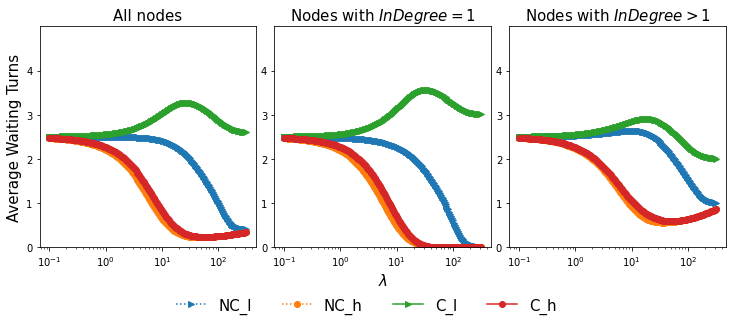

In [180]:
# Calculate the average waiting turns for each treatment, ndoes with 1 or multiple information 
turns = np.array([0,1,2,3,4,5])
QREs = [QRE_a_l, QRE_a_h, QRE_b_l, QRE_b_h]
TreatmentName = ['NC_l','NC_h', 'C_l', 'C_h']
Network = ['nc', 'nc', 'c','c']
Cost = ['l','h','l','h']

avg_turn = np.empty((4,n,5))
for t in range(4):
    for i in range(n):
        QRE = QREs[t]
        x = QRE[i]*turns
        avg_turn[t][i] = x.sum(axis=1)


fig, axes = plt.subplots(nrows=1, ncols=3,  sharex=True,   constrained_layout=True, figsize=(10,4))
fig.set_constrained_layout_pads( w_pad=1 / 100)

linestyle = {'c':'-', 'nc':':'}
markerstyle = {'l': '>', 'h': 'o' }
y_max = 5
y_step = 1

# Defining custom 'xlim' and 'ylim' values.
# custom_xlim = (1, 11)
custom_ylim = (0, y_max)
# custom_xtick = np.arange(1,11,step=1)
custom_ytick = np.arange(0,y_max,step=y_step)
# custom_xticklabel = [1,5,10]

plt.setp(axes, yticks= custom_ytick, ylim=custom_ylim)

for t in range(4):
    axes[0].plot(lambd,avg_turn[t].mean(axis=1), label=str(TreatmentName[t]),
               linestyle=linestyle[Network[t]], marker=markerstyle[Cost[t]])
    axes[0].set_title('All nodes', fontsize=15) 
    
    if t<=1:
        axes[1].plot(lambd,avg_turn[t, :, [0,3,4]].mean(axis=0), label=str(TreatmentName[t]),
               linestyle=linestyle[Network[t]], marker=markerstyle[Cost[t]])
    else : 
        axes[1].plot(lambd,avg_turn[t, :, [2,3,4]].mean(axis=0), label=str(TreatmentName[t]),
               linestyle=linestyle[Network[t]], marker=markerstyle[Cost[t]])
    axes[1].set_title('Nodes with $InDegree=1$', fontsize=15) 
    
    
    if t<=1:
        axes[2].plot(lambd,avg_turn[t, :, [1,2]].mean(axis=0), label=str(TreatmentName[t]),
               linestyle=linestyle[Network[t]], marker=markerstyle[Cost[t]])
    else : 
        axes[2].plot(lambd,avg_turn[t, :, [0,1]].mean(axis=0), label=str(TreatmentName[t]),
               linestyle=linestyle[Network[t]], marker=markerstyle[Cost[t]])

    axes[2].set_title('Nodes with $InDegree>1$', fontsize=15) 
    
    axes[1].set_xlabel('$\lambda$', fontsize=15)
    axes[0].set_ylabel('Average Waiting Turns', fontsize=15)
    axes[0].set_xscale('log')
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(.5,-0.05), loc="center" , ncol=4, frameon=False, prop={'size':15})
fig.savefig("..\\Output_Figures\\05-QRE-Calculation\\"+"QRE_Normal_AvgTurns"  , bbox_inches="tight")  



In [19]:
waiting_distr =  pd.read_csv('..\\ImportedData\\03-Experiment-Analysis-Summary-Statistics-WaitingDist_m.csv')
waiting_distr

app_name network waiting_cost    0.0    1.0    2.0   3.0   4.0   5.0  Early  \
0      dcn       c            h  17.50  65.42  17.08   NaN   NaN   NaN  17.50   
1      dcn       c            l  16.50  44.17  35.17  4.17   NaN   NaN  49.83   
2      dcn      nc            h  15.42  66.67  17.08  0.83   NaN   NaN  15.42   
3      dcn      nc            l  11.35  56.35  25.00  5.19  0.96  1.15  46.92   

    Late  Optimal  
0  17.08    65.42  
1   6.50    43.67  
2  17.92    66.67  
3  13.46    39.62

In [20]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    nearest_value = array[idx]
    return idx

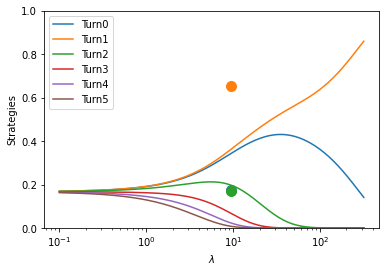

In [26]:
# Adding the empirical prob distribution 
# Use the multiple information source as an example
waiting_distr =  pd.read_csv('..\\ImportedData\\03-Experiment-Analysis-Summary-Statistics-WaitingDist_m.csv')

column_names = ['0.0', '1.0', '2.0','3.0','4.0','5.0']
estimated_lamda = [8.959 , 6.748, 8.959 , 9.329]

treatment_cond = (waiting_distr['network']=='c') & (waiting_distr['waiting_cost']=='h')
QRE_data = QRE_b_h 
lamda_e = estimated_lamda[3]
name= "-b-h-"

i = 1 # Node B is always the indegree=3
fig, ax = plt.subplots()
ax.set_xlabel('$\lambda$')
ax.set_ylabel('Strategies')
handles, labels = ax.get_legend_handles_labels()
# ax.set_title("QRE for Nodes with Single Information Source")
ax.set_ylim(0, 1)
ax.set_xscale('log')
for j in range(6):
    ax.plot(lambd,QRE_data[:,i,j], label='Turn'+str(j))
    distr = float(waiting_distr[treatment_cond][column_names[j]])/100
#     idx = find_nearest(QRE_a_l[:,i,j], distr) # this is to find the closes dot on the QRE line
#     ax.scatter(lambd[idx], distr, marker='o', s=100)
    ax.scatter(lamda_e, distr, marker='o', s=100)

ax.legend()
fig.savefig("..\\Output_Figures\\05-QRE-Calculation\\"+"QRE"+name+"mSource", bbox_inches="tight")  


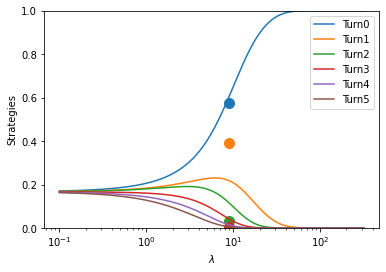

In [31]:
# Adding the empirical prob distribution 
# Use the multiple information source as an example
waiting_distr =  pd.read_csv('..\\ImportedData\\03-Experiment-Analysis-Summary-Statistics-WaitingDist_s.csv')

column_names = ['0.0', '1.0', '2.0','3.0','4.0','5.0']
estimated_lamda = [11.895 , 8.959 , 4.322 , 6.223]

treatment_cond = (waiting_distr['network']=='nc') & (waiting_distr['waiting_cost']=='h')
QRE_data = QRE_a_h 
lamda_e = estimated_lamda[1]
name= "-a-h-"

i = 3   # Node D is always the indegree=1 (comparable)
fig, ax = plt.subplots()
ax.set_xlabel('$\lambda$')
ax.set_ylabel('Strategies')
handles, labels = ax.get_legend_handles_labels()
# ax.set_title("QRE for Nodes with Single Information Source")
ax.set_ylim(0, 1)
ax.set_xscale('log')
for j in range(6):
    ax.plot(lambd,QRE_data[:,i,j], label='Turn'+str(j))
    distr = float(waiting_distr[treatment_cond][column_names[j]])/100
#     idx = find_nearest(QRE_a_l[:,i,j], distr) # this is to find the closes dot on the QRE line
#     ax.scatter(lambd[idx], distr, marker='o', s=100)
    ax.scatter(lamda_e, distr, marker='o', s=100)

ax.legend()
fig.savefig("..\\Output_Figures\\05-QRE-Calculation\\"+"QRE"+name+"sSource", bbox_inches="tight")  


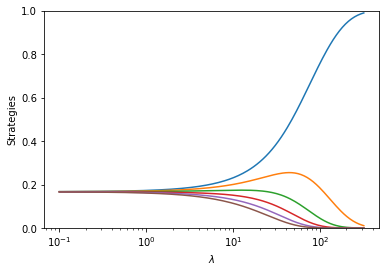

In [33]:
# a-l Node A/E's graph:
treatment_cond = (waiting_distr['network']=='nc') & (waiting_distr['waiting_cost']=='l')
QRE_data = QRE_a_l 
lamda_e = estimated_lamda[0]
name= "-a-l-"

i = 0   # Node D is always the indegree=1 (comparable)
fig, ax = plt.subplots()
ax.set_xlabel('$\lambda$')
ax.set_ylabel('Strategies')
handles, labels = ax.get_legend_handles_labels()
# ax.set_title("QRE for Nodes with Single Information Source")
ax.set_ylim(0, 1)
ax.set_xscale('log')
for j in range(6):
    ax.plot(lambd,QRE_data[:,i,j], label='Turn'+str(j))
    distr = float(waiting_distr[treatment_cond][column_names[j]])/100
#     idx = find_nearest(QRE_a_l[:,i,j], distr) # this is to find the closes dot on the QRE line
#     ax.scatter(lambd[idx], distr, marker='o', s=100)
#     ax.scatter(lamda_e, distr, marker='o', s=100)

# Estimate lambda

-[Return](#Content)

In [38]:
# Step 4 b. Use the calculated QRE to estimate logL
# datafolder = "C:\\Users\\xinxi\\Purdue\\EffectiveSocialLearningProject\\DataAnalysis\\RawData\\Session_Formal"
datafolder = "..\\RawData\\Session_Formal"
datafolder2 = "..\\ImportedData\\"
outputfolder = "..\\Output_Figures\\" 

# Import data

data  = pd.read_csv(datafolder2+"02-Experiment-Clean-Data.csv")

for col in data.columns:
    if type(data[col].unique()[1]) == str:
        data[col] = data[col].str.lower()

# Change the rounds into matches  
data.loc[data['app_name']=='pdcn', 'match'] = data['.subsession.round_number']
condition = data['app_name']=='dcn'
data.loc[condition, 'match'] = ((data.loc[condition, '.subsession.round_number'] -1)/ 3).astype(int) +1 
condition = (data['app_name']=='dcn') & (data['date']=='03/19/2021')
data.loc[condition, 'match'] = ((data.loc[condition, '.subsession.round_number'] -1)/ 4).astype(int) +1 
# data['match'] = data['.subsession.round_number']
data[['match', 'app_name', '.subsession.round_number']]

# DataExperiment= data[data['app_name']=='dcn'] 
DataExperiment= data[(data['app_name']=='dcn') & (data['.subsession.round_number']>=1)]


# Count any variable will be the same

BySessions = DataExperiment.groupby(['network', 'waiting_cost','session.code',
                                     '.player.type','.player.period']).count().reset_index()
BySessions = BySessions[['network', 'waiting_cost','session.code',
                                     '.player.type','.player.period','date']]

ByIndividuals = DataExperiment.groupby(['network', 'waiting_cost','participant.code',
                                     '.player.type','.player.period']).count().reset_index()
ByIndividuals = ByIndividuals[['network', 'waiting_cost','participant.code',
                                     '.player.type','.player.period','date']]

# BySessions['session.code'].unique()
ByIndividuals
# BySessions.pivot(index=['network', 'waiting_cost','session.code','.player.type'], columns='.player.period')

network waiting_cost participant.code .player.type  .player.period  date
0          c            h         1tkgpojc            a             2.0     4
1          c            h         1tkgpojc            a             3.0     2
2          c            h         1tkgpojc            b             1.0     1
3          c            h         1tkgpojc            b             2.0     4
4          c            h         1tkgpojc            b             3.0     1
...      ...          ...              ...          ...             ...   ...
1434      nc            l         z1pxbhxi            c             3.0     1
1435      nc            l         z1pxbhxi            d             2.0     5
1436      nc            l         z1pxbhxi            d             3.0     3
1437      nc            l         z1pxbhxi            e             1.0     5
1438      nc            l         z1pxbhxi            e             2.0     3

[1439 rows x 6 columns]

In [150]:
# By treatments

QREs =np.array([[QRE_a_l, QRE_a_h], [QRE_b_l, QRE_b_h]])

nn = 200
EstimatedL =  np.empty((2,2))
EstimatedLogl =  np.empty((2,2))
for n,network in enumerate(['nc', 'c']):
    for l,waitingcost in enumerate(['l','h']):
        logL =  np.zeros(nn)
        for i in range(nn):
            QRE_lamda=QREs[n,l][i]
            for pos, node in enumerate(['a','b','c','d','e']):
                for turn in range(6):
                    freq = BySessions.loc[(BySessions['network']==network) & 
                       (BySessions['waiting_cost']==waitingcost) &
                      (BySessions['.player.type']==node) & 
                     (BySessions['.player.period']==turn) , 'date' ].sum()
                    logL[i] += freq*np.log(QRE_lamda[pos,turn])
        logL = logL[~np.isnan(logL)]
        max_l = np.argmax(logL)
        EstimatedLogl[n,l] = logL[max_l]
        EstimatedL[n,l] = lambd[max_l]
EstimatedL

array([[15.16716888,  8.2620045 ],
       [ 3.38961797,  5.97560538]])

In [151]:
# Normalize the payoffs by dividing 70 gives me reasonable lambda 
EstimatedL

# For all 30 rounds

# array([[15.16716888,  8.2620045 ],
#        [ 3.38961797,  5.97560538]])
# For latter 15 rounds

# array([[67.86694366,  8.95903651],
#        [ 3.38961797,  5.97560538]])

array([[15.16716888,  8.2620045 ],
       [ 3.38961797,  5.97560538]])

In [152]:
EstimatedLogl  # because logL also depends on how many observations I have

# For all 30 rounds
# array([[-2261.51087696,  -750.97797749],
#        [-2662.99031181,  -907.86025399]])
# For latter 15 rounds
# array([[-1250.66311514,  -383.79953918],
#        [-1419.69653271,  -483.66594404]])

array([[-2261.51087696,  -750.97797749],
       [-2662.99031181,  -907.86025399]])

In [84]:
# By treatments and information sources: multiple sources 

QREs =np.array([[QRE_a_l, QRE_a_h], [QRE_b_l, QRE_b_h]])

nn = 200
EstimatedL =  np.empty((2,2))
EstimatedLogl =  np.empty((2,2))
for n,network in enumerate(['nc', 'c']):
    for l,waitingcost in enumerate(['l','h']):
        logL =  np.zeros(nn)
        for i in range(nn):
            QRE_lamda=QREs[n,l][i]
            if n=='nc':
                list_infor = ['b','c']
            else :
                list_infor = ['b','a']
            for pos, node in enumerate(list_infor):
                for turn in range(6):
                    freq = BySessions.loc[(BySessions['network']==network) & 
                       (BySessions['waiting_cost']==waitingcost) &
                      (BySessions['.player.type']==node) & 
                     (BySessions['.player.period']==turn) , 'date' ].sum()
                    logL[i] += freq*np.log(QRE_lamda[pos,turn])
        logL = logL[~np.isnan(logL)]
        max_l = np.argmax(logL)
        EstimatedLogl[n,l] = logL[max_l]
        EstimatedL[n,l] = lambd[max_l]
print(EstimatedL)
print(EstimatedLogl)

# 30 rounds
# [[8.95903651 6.74754405]
#  [8.95903651 9.32930403]]
# [[ -913.07553497  -327.3827763 ]
#  [-1026.52455389  -324.81681414]]

[[8.95903651 6.74754405]
 [8.95903651 9.32930403]]
[[ -913.07553497  -327.3827763 ]
 [-1026.52455389  -324.81681414]]


In [85]:
# By treatments and information sources: single sources 

QREs =np.array([[QRE_a_l, QRE_a_h], [QRE_b_l, QRE_b_h]])

nn = 200
EstimatedL =  np.empty((2,2))
EstimatedLogl =  np.empty((2,2))
for n,network in enumerate(['nc', 'c']):
    for l,waitingcost in enumerate(['l','h']):
        logL =  np.zeros(nn)
        for i in range(nn):
            QRE_lamda=QREs[n,l][i]
            if n=='nc':
                list_infor = ['a','d','e']
            else :
                list_infor = ['c','d','e']
            for pos, node in enumerate(list_infor):
                for turn in range(6):
                    freq = BySessions.loc[(BySessions['network']==network) & 
                       (BySessions['waiting_cost']==waitingcost) &
                      (BySessions['.player.type']==node) & 
                     (BySessions['.player.period']==turn) , 'date' ].sum()
                    logL[i] += freq*np.log(QRE_lamda[pos,turn])
        logL = logL[~np.isnan(logL)]
        max_l = np.argmax(logL)
        EstimatedLogl[n,l] = logL[max_l]
        EstimatedL[n,l] = lambd[max_l]
print(EstimatedL)
print(EstimatedLogl)

# 30 rounds:

# [[11.89534067  8.95903651]
#  [ 4.3219366   6.22257084]]
# [[-1352.09390136  -442.24833978]
#  [-1589.60767198  -542.3661108 ]]

[[11.89534067  8.95903651]
 [ 4.3219366   6.22257084]]
[[-1352.09390136  -442.24833978]
 [-1589.60767198  -542.3661108 ]]


In [167]:
# BySessions['session.code'].unique()

ss = "hyi8cnuz"
BySessions[BySessions['session.code']==ss]

network waiting_cost session.code .player.type  .player.period  date
0        c            h     hyi8cnuz            a             0.0     7
1        c            h     hyi8cnuz            a             1.0    33
2        c            h     hyi8cnuz            a             2.0    20
3        c            h     hyi8cnuz            b             0.0     6
4        c            h     hyi8cnuz            b             1.0    31
5        c            h     hyi8cnuz            b             2.0    23
6        c            h     hyi8cnuz            c             0.0    11
7        c            h     hyi8cnuz            c             1.0    22
8        c            h     hyi8cnuz            c             2.0    26
9        c            h     hyi8cnuz            c             3.0     1
10       c            h     hyi8cnuz            d             0.0    11
11       c            h     hyi8cnuz            d             1.0    20
12       c            h     hyi8cnuz            d             2.0    27
13       c            h     hyi8cnuz            d             3.0     2
14       c            h     hyi8cnuz            e             0.0     8
15       c            h     hyi8cnuz            e             1.0    23
16       c            h     hyi8cnuz            e             2.0    29

In [168]:
# By Sessions

QREs =np.array([[QRE_a_l, QRE_a_h], [QRE_b_l, QRE_b_h]])

nn = 200
Sessions = BySessions['session.code'].unique()
outcome = pd.DataFrame(columns = ["SessionCode", "Network", "WaitingCost","EstimatedL","EstimatedLogl"])

EstimatedLogl =  np.empty((len(Sessions),5))
for s_n, ss in enumerate(Sessions):
    EstimatedLogl[s_n, 0]= s_n
    data = BySessions[BySessions['session.code']==ss]
    if BySessions[BySessions['session.code']==ss].network.unique()[0]=='c': 
        n = 1
        
    else :
        n = 0 
    
    if BySessions[BySessions['session.code']==ss].waiting_cost.unique()[0]=='l':
        l = 0
    else :
        l = 1
    EstimatedLogl[s_n, 1]= n
    EstimatedLogl[s_n, 2]= l
    logL =  np.zeros(nn)
    for i in range(nn):
        QRE_lamda=QREs[n,l][i]
        for pos, node in enumerate(['a','b','c','d','e']):
            for turn in range(6):
                freq = data.loc[(data['.player.type']==node) & 
                 (data['.player.period']==turn) , 'date' ].sum()
                logL[i] += freq*np.log(QRE_lamda[pos,turn])
    logL = logL[~np.isnan(logL)]
    max_l = np.argmax(logL)            
    EstimatedLogl[s_n, 3]= lambd[max_l]
    EstimatedLogl[s_n, 4]= logL[max_l]            
                
                    
#     for l,waitingcost in enumerate(['l','h']):
#         logL =  np.zeros(nn)
#         for i in range(nn):
#             QRE_lamda=QREs[n,l][i]
#             for pos, node in enumerate(['a','b','c','d','e']):
#                 for turn in range(6):
#                     freq = BySessions.loc[(BySessions['network']==network) & 
#                        (BySessions['waiting_cost']==waitingcost) &
#                       (BySessions['.player.type']==node) & 
#                      (BySessions['.player.period']==turn) , 'date' ].sum()
#                     logL[i] += freq*np.log(QRE_lamda[pos,turn])
#         logL = logL[~np.isnan(logL)]
#         max_l = np.argmax(logL)
#         EstimatedLogl[n,l] = logL[max_l]
#         EstimatedL[n,l] = lambd[max_l]
# EstimatedL

In [172]:
np.set_printoptions(suppress=True)
EstimatedLogl.round(3)

# 30 rounds:
# array([[   0.   ,    1.   ,    1.   ,    7.026, -430.157],
#        [   1.   ,    1.   ,    1.   ,    4.88 , -473.363],
#        [   2.   ,    1.   ,    0.   ,    0.1  , -537.888],
#        [   3.   ,    1.   ,    0.   ,   13.987, -475.817],
#        [   4.   ,    1.   ,    0.   ,    1.508, -536.496],
#        [   5.   ,    1.   ,    0.   ,    8.262, -512.119],
#        [   6.   ,    1.   ,    0.   ,    1.773, -536.055],
#        [   7.   ,    0.   ,    1.   ,    8.262, -368.741],
#        [   8.   ,    0.   ,    1.   ,    7.934, -382.004],
#        [   9.   ,    0.   ,    0.   ,    0.789, -537.438],
#        [  10.   ,    0.   ,    0.   ,    5.292, -534.66 ],
#        [  11.   ,    0.   ,    0.   ,   45.267, -645.031],
#        [  12.   ,    0.   ,    0.   ,   62.587, -482.719]])

array([[   0.   ,    1.   ,    1.   ,    7.026, -430.157],
       [   1.   ,    1.   ,    1.   ,    4.88 , -473.363],
       [   2.   ,    1.   ,    0.   ,    0.1  , -537.888],
       [   3.   ,    1.   ,    0.   ,   13.987, -475.817],
       [   4.   ,    1.   ,    0.   ,    1.508, -536.496],
       [   5.   ,    1.   ,    0.   ,    8.262, -512.119],
       [   6.   ,    1.   ,    0.   ,    1.773, -536.055],
       [   7.   ,    0.   ,    1.   ,    8.262, -368.741],
       [   8.   ,    0.   ,    1.   ,    7.934, -382.004],
       [   9.   ,    0.   ,    0.   ,    0.789, -537.438],
       [  10.   ,    0.   ,    0.   ,    5.292, -534.66 ],
       [  11.   ,    0.   ,    0.   ,   45.267, -645.031],
       [  12.   ,    0.   ,    0.   ,   62.587, -482.719]])

In [40]:
ByIndividuals

network waiting_cost participant.code .player.type  .player.period  date
0          c            h         1tkgpojc            a             2.0     4
1          c            h         1tkgpojc            a             3.0     2
2          c            h         1tkgpojc            b             1.0     1
3          c            h         1tkgpojc            b             2.0     4
4          c            h         1tkgpojc            b             3.0     1
...      ...          ...              ...          ...             ...   ...
1434      nc            l         z1pxbhxi            c             3.0     1
1435      nc            l         z1pxbhxi            d             2.0     5
1436      nc            l         z1pxbhxi            d             3.0     3
1437      nc            l         z1pxbhxi            e             1.0     5
1438      nc            l         z1pxbhxi            e             2.0     3

[1439 rows x 6 columns]

In [55]:
# By Individuals


QREs =np.array([[QRE_a_l, QRE_a_h], [QRE_b_l, QRE_b_h]])

nn = 200
Sessions = ByIndividuals['participant.code'].unique()
outcome = pd.DataFrame(columns = ["ParticipantCode", "Network", "WaitingCost","EstimatedL","EstimatedLogl"])

EstimatedLogl =  np.empty((len(Sessions),5))
for s_n, ss in enumerate(Sessions):
    print(s_n)
    EstimatedLogl[s_n, 0]= s_n
    data = ByIndividuals[ByIndividuals['participant.code']==ss]
    if ByIndividuals[ByIndividuals['participant.code']==ss].network.unique()[0]=='c': 
        n = 1
        
    else :
        n = 0 
    
    if ByIndividuals[ByIndividuals['participant.code']==ss].waiting_cost.unique()[0]=='l':
        l = 0
    else :
        l = 1
    EstimatedLogl[s_n, 1]= n
    EstimatedLogl[s_n, 2]= l
    logL =  np.zeros(nn)
    for i in range(nn):
        QRE_lamda=QREs[n,l][i]
        for pos, node in enumerate(['a','b','c','d','e']):
            for turn in range(6):
                freq = data.loc[(data['.player.type']==node) & 
                 (data['.player.period']==turn) , 'date' ].sum()
                logL[i] += freq*np.log(QRE_lamda[pos,turn])
    logL = logL[~np.isnan(logL)]
    max_l = np.argmax(logL)            
    EstimatedLogl[s_n, 3]= lambd[max_l]
    EstimatedLogl[s_n, 4]= logL[max_l]            
    outcome.loc[len(outcome.index)] = [ss, n, l, lambd[max_l], logL[max_l]  ]
                
np.set_printoptions(suppress=True)
print('LogL')
print(EstimatedLogl.round(3))


#     for l,waitingcost in enumerate(['l','h']):
#         logL =  np.zeros(nn)
#         for i in range(nn):
#             QRE_lamda=QREs[n,l][i]
#             for pos, node in enumerate(['a','b','c','d','e']):
#                 for turn in range(6):
#                     freq = ByIndividuals.loc[(ByIndividuals['network']==network) & 
#                        (ByIndividuals['waiting_cost']==waitingcost) &
#                       (ByIndividuals['.player.type']==node) & 
#                      (ByIndividuals['.player.period']==turn) , 'date' ].sum()
#                     logL[i] += freq*np.log(QRE_lamda[pos,turn])
#         logL = logL[~np.isnan(logL)]
#         max_l = np.argmax(logL)
#         EstimatedLogl[n,l] = logL[max_l]
#         EstimatedL[n,l] = lambd[max_l]
# EstimatedL

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
LogL
[[  0.      1.      1.      3.827 -49.578]
 [  1.      1.      1.     12.387 -31.844]
 [  2.      1.      1.      8.262 -40.659]
 [  3.      1.      1.      8.959 -38.227]
 [  4.      1.      1.      6.748 -43.634]
 [  5.      1.      1.      5.082 -46.855]
 [  6.      1.      1.      4.88  -47.586]
 [  7.      1.      1.      5.511 -46.057]
 [  8.      1.      1.      5.292 -46.467]
 [  9.      1.      1.      5.082 -47.245]
 [ 10.      1.      1.      4.501 -48.254]
 [ 11.      1.      1.      3.827 -49.473]
 [ 12.      1.      1.      5.738 -45.534]
 [ 13.      1.      1.    

In [58]:
outcome.to_csv(datafolder2+"05-QRE-Calculation-Normalize-Indiv-Estimation.csv",index=False)

In [66]:
outcome['Network'] = outcome['Network'].replace({0:'nc', 1:'c'})
outcome['WaitingCost'] = outcome['WaitingCost'].replace({0:'l', 1:'h'})


In [106]:
outcome['Treatment'] = outcome['Network'] +'-'+ outcome['WaitingCost']
outcome = outcome.sort_values(by=['Treatment'], ascending=False)
outcome

ParticipantCode Network WaitingCost  EstimatedL  EstimatedLogl Treatment
129        z1pxbhxi      nc           l   35.501872     -57.523582      nc-l
110        jttdu2x1      nc           l  135.099352     -29.885545      nc-l
111        k90nedek      nc           l   15.794012     -52.156601      nc-l
128        wvcq0ka1      nc           l   76.634109     -39.190549      nc-l
126        vs2fh0eq      nc           l   86.533831     -43.773118      nc-l
..              ...     ...         ...         ...            ...       ...
4          70lpvw7w       c           h    6.747544     -43.634328       c-h
3          6t09y23e       c           h    8.959037     -38.227400       c-h
2          6ep3453x       c           h    8.262004     -40.658549       c-h
10         hlbiyt4b       c           h    4.500558     -48.254489       c-h
0          1tkgpojc       c           h    3.827494     -49.578063       c-h

[130 rows x 6 columns]

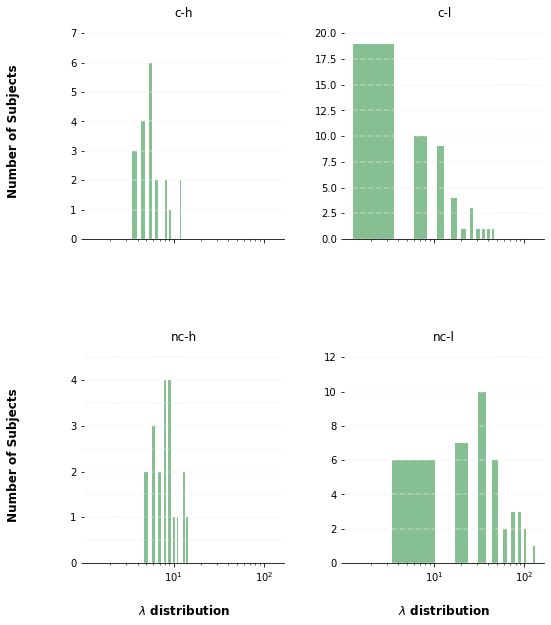

In [138]:

ax = outcome.hist(column='EstimatedL', by='Treatment',
                    grid=False, figsize=(8,10), layout=(2,2), sharex=True,
                    color='#86bf91', zorder=1, rwidth=.5)

# ax = ax[0]

for i,xx in enumerate(ax):
    for j,x in enumerate(xx):
    
        # Despine
        x.spines['right'].set_visible(False)
        x.spines['top'].set_visible(False)
        x.spines['left'].set_visible(False)

        # Switch off ticks
#         x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")
        x.set_xticks(lambd)
        x.set_xscale('log')
    #     # Draw horizontal axis lines
        vals = x.get_yticks()
        for tick in vals:
            x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    #     # Set x-axis label
        x.set_xlabel("$\lambda$ distribution", labelpad=20, weight='bold', size=12)

    #     # Set y-axis label
        if j == 0:
            x.set_ylabel("Number of Subjects", labelpad=50, weight='bold', size=12)

    #     # Format y-axis label
    #     x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

        x.tick_params(axis='x', rotation=0)


plt.savefig(outputfolder+"05-QRE-Calculation\\Normalize-Indvd-Lambda-Distr"  , bbox_inches="tight")  

In [93]:
for i,x in enumerate(ax):
    print(i)
    print(x)

0
[<AxesSubplot:title={'center':'c-h'}> <AxesSubplot:title={'center':'c-l'}>]
1
[<AxesSubplot:title={'center':'nc-h'}>
 <AxesSubplot:title={'center':'nc-l'}>]


In [177]:
# By Sessions, only later 15


DataExperiment= data[(data['app_name']=='dcn') & (data['.subsession.round_number']>=15)]


# Count any variable will be the same

BySessions = DataExperiment.groupby(['network', 'waiting_cost','session.code',
                                     '.player.type','.player.period']).count().reset_index()
BySessions = BySessions[['network', 'waiting_cost','session.code',
                                     '.player.type','.player.period','date']]

QREs =np.array([[QRE_a_l, QRE_a_h], [QRE_b_l, QRE_b_h]])

nn = 200
Sessions = BySessions['session.code'].unique()
outcome = pd.DataFrame(columns = ["SessionCode", "Network", "WaitingCost","EstimatedL","EstimatedLogl"])

EstimatedLogl =  np.empty((len(Sessions),5))
for s_n, ss in enumerate(Sessions):
    EstimatedLogl[s_n, 0]= s_n
    data_s = BySessions[BySessions['session.code']==ss]
    if BySessions[BySessions['session.code']==ss].network.unique()[0]=='c': 
        n = 1
        
    else :
        n = 0 
    
    if BySessions[BySessions['session.code']==ss].waiting_cost.unique()[0]=='l':
        l = 0
    else :
        l = 1
    EstimatedLogl[s_n, 1]= n
    EstimatedLogl[s_n, 2]= l
    logL =  np.zeros(nn)
    for i in range(nn):
        QRE_lamda=QREs[n,l][i]
        for pos, node in enumerate(['a','b','c','d','e']):
            for turn in range(6):
                freq = data_s.loc[(data_s['.player.type']==node) & 
                 (data_s['.player.period']==turn) , 'date' ].sum()
                logL[i] += freq*np.log(QRE_lamda[pos,turn])
    logL = logL[~np.isnan(logL)]
    max_l = np.argmax(logL)            
    EstimatedLogl[s_n, 3]= lambd[max_l]
    EstimatedLogl[s_n, 4]= logL[max_l]            
                
                    
#     for l,waitingcost in enumerate(['l','h']):
#         logL =  np.zeros(nn)
#         for i in range(nn):
#             QRE_lamda=QREs[n,l][i]
#             for pos, node in enumerate(['a','b','c','d','e']):
#                 for turn in range(6):
#                     freq = BySessions.loc[(BySessions['network']==network) & 
#                        (BySessions['waiting_cost']==waitingcost) &
#                       (BySessions['.player.type']==node) & 
#                      (BySessions['.player.period']==turn) , 'date' ].sum()
#                     logL[i] += freq*np.log(QRE_lamda[pos,turn])
#         logL = logL[~np.isnan(logL)]
#         max_l = np.argmax(logL)
#         EstimatedLogl[n,l] = logL[max_l]
#         EstimatedL[n,l] = lambd[max_l]
# EstimatedL

In [180]:
np.set_printoptions(suppress=True)
EstimatedLogl.round(3)

# Only later 15 rounds
# Huge session differences, driven by individual differences? 
# array([[   0.   ,    1.   ,    1.   ,    7.934, -219.579],
#        [   1.   ,    1.   ,    1.   ,    4.322, -257.881],
#        [   2.   ,    1.   ,    0.   ,    0.1  , -286.911],
#        [   3.   ,    1.   ,    0.   ,   14.565, -251.02 ],
#        [   4.   ,    1.   ,    0.   ,    1.773, -285.915],
#        [   5.   ,    1.   ,    0.   ,   12.387, -260.036],
#        [   6.   ,    1.   ,    0.   ,    0.216, -286.669],
#        [   7.   ,    0.   ,    1.   ,    8.959, -190.347],
#        [   8.   ,    0.   ,    1.   ,    8.959, -193.452],
#        [   9.   ,    0.   ,    0.   ,    4.88 , -285.247],
#        [  10.   ,    0.   ,    0.   ,   90.11 , -285.182],
#        [  11.   ,    0.   ,    0.   ,   49.086, -400.545],
#        [  12.   ,    0.   ,    0.   ,   79.801, -250.579]])

array([[   0.   ,    1.   ,    1.   ,    7.934, -219.579],
       [   1.   ,    1.   ,    1.   ,    4.322, -257.881],
       [   2.   ,    1.   ,    0.   ,    0.1  , -286.911],
       [   3.   ,    1.   ,    0.   ,   14.565, -251.02 ],
       [   4.   ,    1.   ,    0.   ,    1.773, -285.915],
       [   5.   ,    1.   ,    0.   ,   12.387, -260.036],
       [   6.   ,    1.   ,    0.   ,    0.216, -286.669],
       [   7.   ,    0.   ,    1.   ,    8.959, -190.347],
       [   8.   ,    0.   ,    1.   ,    8.959, -193.452],
       [   9.   ,    0.   ,    0.   ,    4.88 , -285.247],
       [  10.   ,    0.   ,    0.   ,   90.11 , -285.182],
       [  11.   ,    0.   ,    0.   ,   49.086, -400.545],
       [  12.   ,    0.   ,    0.   ,   79.801, -250.579]])

In [ ]:
# By information source (only later 15 rounds)

In [ ]:
# By individual (only later 15 rounds)

NameError: name 'p' is not defined

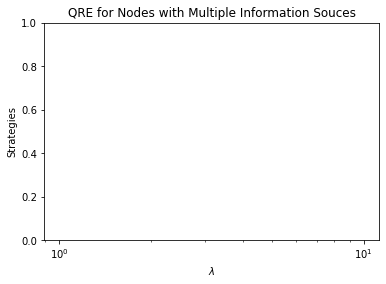

In [35]:
# Step 4 a. Draw QRE Graphs (additional)
# Node_positions = ['A', 'B', 'C','D','E']

# # For each node
# for i in range(5):
#     fig, ax = plt.subplots()
#     ax.set_xlabel('$\lambda$')
#     ax.set_ylabel('Strategies')
#     handles, labels = ax.get_legend_handles_labels()
#     ax.set_title("QRE for Node"+ Node_positions[i])
#     ax.set_ylim(0, 1)
#     ax.set_xscale('log')
#     for j in range(5):
#         ax.plot(lambd,p[:,i,j], label='Turn'+str(j))
#     ax.legend()

# By Indegree
i = 1 # Node B is always the indegree=3
fig, ax = plt.subplots()
ax.set_xlabel('$\lambda$')
ax.set_ylabel('Strategies')
handles, labels = ax.get_legend_handles_labels()
ax.set_title("QRE for Nodes with Multiple Information Souces")
ax.set_ylim(0, 1)
ax.set_xscale('log')
for j in range(5):
    ax.plot(lambd,p[:,i,j], label='Turn'+str(j))
ax.legend()

i = 3 # Node E is always the indegree=1
fig, ax = plt.subplots()
ax.set_xlabel('$\lambda$')
ax.set_ylabel('Strategies')
handles, labels = ax.get_legend_handles_labels()
ax.set_title("QRE for Nodes with Single Information Source")
ax.set_ylim(0, 1)
ax.set_xscale('log')
for j in range(5):
    ax.plot(lambd,p[:,i,j], label='Turn'+str(j))
ax.legend()

C:\Users\xinxi\AppData\Local\Temp/ipykernel_11364/1544125704.py:18: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  lgd = ax.legend(handles, labels = labels, loc = 0)


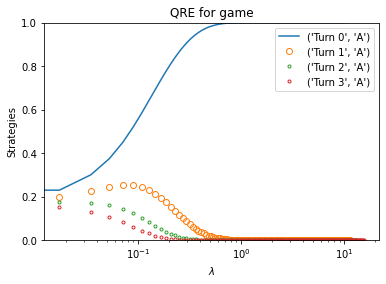

In [124]:

fig, ax = plt.subplots()
ax.set_xlabel('$\lambda$')
ax.set_ylabel('Strategies')
handles, labels = ax.get_legend_handles_labels()
ax.set_title("QRE for game")
ax.set_ylim(0, 1)
ax.set_xscale('log')
for i in range(1):
    ax.plot(lambd,p[:,i,0])
    ax.plot(lambd,p[:,i,1],'o',markerfacecolor = "none")
    ax.plot(lambd,p[:,i,2],'.',markerfacecolor = "none")
    ax.plot(lambd,p[:,i,3],'.',markerfacecolor = "none")
    labels.append(('Turn 0', Node_positions[i]))
    labels.append(('Turn 1', Node_positions[i]))
    labels.append(('Turn 2', Node_positions[i]))
    labels.append(('Turn 3', Node_positions[i]))

lgd = ax.legend(handles, labels = labels, loc = 0)         

C:\Users\xinxi\AppData\Local\Temp/ipykernel_11364/794840202.py:18: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  lgd = ax.legend(handles, labels = labels, loc = 0)


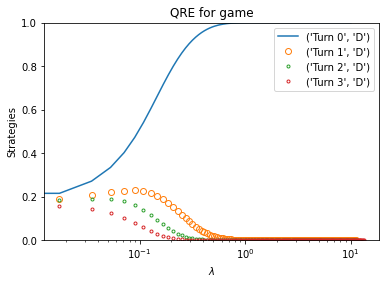

In [125]:

fig, ax = plt.subplots()
ax.set_xlabel('$\lambda$')
ax.set_ylabel('Strategies')
handles, labels = ax.get_legend_handles_labels()
ax.set_title("QRE for game")
ax.set_ylim(0, 1)
ax.set_xscale('log')
i=3
ax.plot(lambd,p[:,i,0])
ax.plot(lambd,p[:,i,1],'o',markerfacecolor = "none")
ax.plot(lambd,p[:,i,2],'.',markerfacecolor = "none")
ax.plot(lambd,p[:,i,3],'.',markerfacecolor = "none")
labels.append(('Turn 0', Node_positions[i]))
labels.append(('Turn 1', Node_positions[i]))
labels.append(('Turn 2', Node_positions[i]))
labels.append(('Turn 3', Node_positions[i]))

lgd = ax.legend(handles, labels = labels, loc = 0)         

In [126]:
p

array([[[0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
         0.16666667],
        [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
         0.16666667],
        [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
         0.16666667],
        [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
         0.16666667],
        [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
         0.16666667]],

       [[0.22918537, 0.19953418, 0.17371916, 0.15124399, 0.13167658,
         0.11464073],
        [0.19604177, 0.19740452, 0.18444531, 0.16058243, 0.13980684,
         0.12171913],
        [0.20450215, 0.20592371, 0.17928203, 0.15608716, 0.13589316,
         0.11831178],
        [0.21463548, 0.1868667 , 0.18199561, 0.15844967, 0.13795001,
         0.12010253],
        [0.21463548, 0.1868667 , 0.18199561, 0.15844967, 0.13795001,
         0.12010253]],

       [[0.29989483, 0.22677113, 0.17147727, 0.12966577, 0.09804922,
         0.074141

# Method 3: Agent Extensive Form Estimation

- [Return](#Content)

In the extensive form game, assume agent is different at each turn. The probability of making a guess at each turn is based on payoffs between making a guess now and the maximal payoff from waiting. 

I only changed the payoff matrix but leave the probability matrix as the following. However, the probability is updated differently, for each node at each turn, I will assume the probability of guess at this turn is 0.5 and then update the probability based on the payoff tradeoff. 


Probability is defined as a matrix of 5*6 (5 nodes, deciding at 6 turns). It is assumed that each subject with a given lambda will pre-determine the probability of makig a prediction at a certain turn, the probability doesn't change based on what new information is updated as time goes by (Not sure what is a more formal/proper way to describe this)


Comment: Got very interesting results!!!

The normal form equilibrium is not the bayesian perfect nash equilibrium ... (Maybe because how we use the max to derive the optimal rule...)

NOTE: NETWORK B EXPECTED PAYOFF UPDATED ONLY FROM HERE!!!!

In [3]:
# Step 1: Define Payoffs for Deciding at each turn; The payoff depends on others' probability of making a prediction 

# Step 2: Write out the policy iteration 

# Step 3: for different lambda value, derive the results

# Step 4: Based on the estimation result, do two things 
# A. Draw QRE for each node for each treatment, show the difference, describe
# B. Estimate MLE based on realized/observed frequencies in each treatment


In [153]:
#Step 1. 
def payoff(pOther,network, cost):
    '''This is for the normal form estimation 
        pOther = matrix(5,6); each row is for each node; each column is for each turn
        '''
    diff_pay = 100
    q = 0.7
    if cost=='h':
        c = 8
    elif cost == 'l':
        c = 1
    
    if network == 'a':
        #In network a, I only consider the pay for A and B, at turn 0 
        pay =  np.empty((5,6),dtype=float)
        pay[:,0] = ProbCorrect_Bayesian(1,q)*diff_pay
        
        # indegree = 1, node A / E
        pay_1 = ProbCorrect_Bayesian(2,q)*diff_pay - c
        pay[0,1] = pay_1 
        pay[4,1] = pay_1 
        j = 2
        while j <= 5:        
            pay[0,j] = ProbCorrect_Bayesian(2,q)*diff_pay - j*c
            pay[4,j] = ProbCorrect_Bayesian(2,q)*diff_pay - j*c
            j += 1
        
        # indegree = 3, node B
        pay_1 = ProbCorrect_Bayesian(4,q)*diff_pay - c
        pi_b = pOther[0,0]*ProbCorrect_Bayesian(4,q)*diff_pay + (1- pOther[0,0])*ProbCorrect_Bayesian(5,q)*diff_pay 
        pay[1,1] = pay_1
        j = 2
        while j <= 5:        
            pay[1,j] = pi_b - j*c
            j += 1

        # indegree = 2, node C
        pay_1 = ProbCorrect_Bayesian(3,q)*diff_pay - c
        pay[2,1] = pay_1
        pi_c = pOther[0, 0]*pOther[1,0]*ProbCorrect_Bayesian(3,q)*diff_pay + ((1-pOther[0, 0])*pOther[1,0] + pOther[0, 0]*(1-pOther[1,0]))*ProbCorrect_Bayesian(4,q)*diff_pay + (1-pOther[0, 0])*(1-pOther[1,0])*ProbCorrect_Bayesian(3,q)*diff_pay
        j = 2
        while j <= 5:        
            pay[2,j] = pi_c - j*c
            j += 1
            
        # indegree = 1, node D (position 3)
        pay_1 = ProbCorrect_Bayesian(2,q)*diff_pay - c
        pay[3,1] = pay_1 
        pi_d = pOther[0,0]*ProbCorrect_Bayesian(2,q)*diff_pay + (1- pOther[0,0])*ProbCorrect_Bayesian(3,q)*diff_pay 
        j = 2
        while j <= 5:        
            pay[3,j] = pi_d - j*c
            j += 1
        
   
        
    elif network == 'b':
         # We know there are 5 nodes, pay matrix is 5X6 ( 6 period)
        pay =  np.empty((5,6),dtype=float)
        pay[:,0] = ProbCorrect_Bayesian(1,q)*diff_pay

        # Note: since here the payoff is about turn 0,1,2, need to do the max in the 
        # indegree = 2, node A
        pay_1 = ProbCorrect_Bayesian(3,q)*diff_pay - c
        pi_a = pOther[1,0]*ProbCorrect_Bayesian(3,q)*diff_pay + (1-pOther[1,0])*ProbCorrect_Bayesian(5,q)*diff_pay        
        pay[0,1] = pay_1
        j = 2
        while j <= 5:        
            pay[0,j] = pi_a - j*c
            j += 1

        # indegree = 3, node B
        pay_1 = ProbCorrect_Bayesian(4,q)*diff_pay - c
        pi_b = pOther[0,0]*ProbCorrect_Bayesian(4,q)*diff_pay + (1- pOther[0,0])*ProbCorrect_Bayesian(5,q)*diff_pay 
        pay[1,1] = pay_1
        j = 2
        while j <= 5:        
            pay[1,j] = pi_b - j*c
            j += 1


        # indegree = 1, node C or D or E, (position 2,3)
        pay_1 = ProbCorrect_Bayesian(2,q)*diff_pay - c
        pay[2:5,1] = pay_1
        # Since in bayesian updating, having 3 or 4 signals carry the same informaiton value, can group these points together
        pi_e0 =  pOther[0,0]*ProbCorrect_Bayesian(2,q)*diff_pay + (1-pOther[0,0])*ProbCorrect_Bayesian(3,q)*diff_pay 
        pay[2:5,2] = pi_e0 - 2*c
        pi_e =  pOther[0,0]*ProbCorrect_Bayesian(2,q)*diff_pay + (pOther[0,1] + (1- pOther[0,0] -pOther[0,1])*pOther[1,0])*ProbCorrect_Bayesian(3,q)*diff_pay  +(1- pOther[0,0] -pOther[0,1])*(1-pOther[1,0])*ProbCorrect_Bayesian(5,q)*diff_pay 
        
        j = 3
        while j <= 5:        
            pay[2:5,j] = pi_e - j*c
            j += 1
#     pay_avg = np.sum(pay,axis=1)
#     return pay/pay_avg[:,None]
    return pay/70
    

In [154]:
# Step 2
def policy_iter(l,p_ini,network, waitingcost, tol = 1e-10):
    
    error = 1
    pOthers = np.ones((5,6))* p_ini
    
    nrep = 1
    while error > tol:
        
        mixed_payoff = payoff(pOthers,network, waitingcost)
        ## Previous code
#         add_error = np.exp(l*mixed_payoff)

#         node_avg =  np.sum(add_error,axis=1)
#         sigma = add_error / node_avg[:,None]
        ## Here update the probability sequentially, using backward induction 
        # Backward induction, from prob guess at turn 4, turn 5 =1-sum(p0:p4):
        sigma = np.zeros((5,6))
        p_guess_byTurn = np.zeros((5,5))
        for i in range(5):
            temp = np.max(mixed_payoff[:, i+1:6],axis=1)
            payoff_relevent = np.zeros((5,2))
            payoff_relevent[:,0] = mixed_payoff[:,i]
            payoff_relevent[:,1] = temp

            payoff_error = np.exp(l*payoff_relevent)
            node_avg =  np.sum(payoff_error,axis=1)
            pi = payoff_error / node_avg[:,None] # (guess, wait)
            
            p_guess_byTurn[:,i] = pi[:,0]
            
        sigma[:,0] = p_guess_byTurn[:,0]
        wait_prob = 1-p_guess_byTurn[:,0]
        for i in range(1,5):
            sigma[:,i] =    wait_prob * p_guess_byTurn[:,i]
            wait_prob *= 1-p_guess_byTurn[:,i]

        sigma[:,5] = 1-np.sum(sigma, axis=1)


        error = np.max(np.sum(np.abs(sigma-pOthers), axis=1))
        pOthers = sigma

        nrep += 1
        
    print("Number of Iterations:",nrep)
    return pOthers
        

In [155]:
# Step 3

# lambd = []
n = 200
lambd = np.logspace(-1, 2.5, n, endpoint=True)
# for i in range(n):
#     lambd.append(1.0173182**i - 1)

def QRE_Outcome(network, waitingCost):
    '''Contains both the prob and graphs'''
    
    p = np.empty((n,5,6))
    for i in range(n):
#         print("Round:", i+1)
        Result = policy_iter(lambd[i],1/6,network,waitingCost)
        p[i] = Result
    
    return p
    


In [156]:
# Obtain the QRE and output QRE figures for extensive form

QRE_a_l = QRE_Outcome('a', 'l')
QRE_a_h = QRE_Outcome('a', 'h')
QRE_b_l = QRE_Outcome('b', 'l')
QRE_b_h = QRE_Outcome('b', 'h')



Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterat

Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterat

Number of Iterations: 5
Number of Iterations: 5
Number of Iterations: 5
Number of Iterations: 5
Number of Iterations: 5
Number of Iterations: 5
Number of Iterations: 5
Number of Iterations: 5
Number of Iterations: 5
Number of Iterations: 5
Number of Iterations: 5
Number of Iterations: 5
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterat

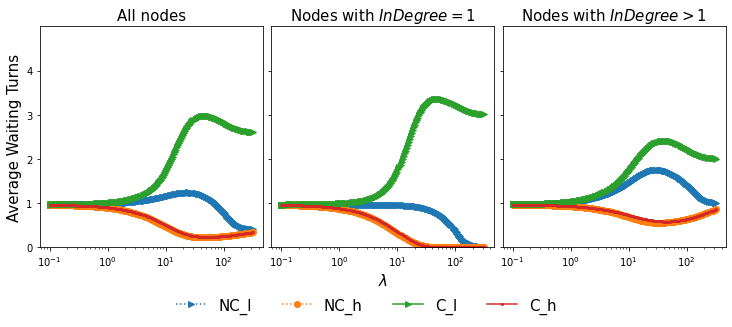

In [172]:
# Calculate the average waiting turns for each treatment, ndoes with 1 or multiple information 
turns = np.array([0,1,2,3,4,5])
QREs = [QRE_a_l, QRE_a_h, QRE_b_l, QRE_b_h]
TreatmentName = ['NC_l','NC_h', 'C_l', 'C_h']
Network = ['nc', 'nc', 'c','c']
Cost = ['l','h','l','h']

avg_turn = np.empty((4,n,5))
for t in range(4):
    for i in range(n):
        QRE = QREs[t]
        x = QRE[i]*turns
        avg_turn[t][i] = x.sum(axis=1)


fig, axes = plt.subplots(nrows=1, ncols=3,  sharex=True,  sharey=True,   constrained_layout=True, figsize=(10,4))
fig.set_constrained_layout_pads( w_pad=1 / 100)

linestyle = {'c':'-', 'nc':':'}
markerstyle = {'l': '>', 'h': 'o' }
y_max = 5
y_step = 1

# Defining custom 'xlim' and 'ylim' values.
# custom_xlim = (1, 11)
custom_ylim = (0, y_max)
# custom_xtick = np.arange(1,11,step=1)
custom_ytick = np.arange(0,y_max,step=y_step)
# custom_xticklabel = [1,5,10]

plt.setp(axes, yticks= custom_ytick, ylim=custom_ylim)

for t in range(4):
    
    if t==3:
        axes[0].plot(lambd,avg_turn[t].mean(axis=1), label=str(TreatmentName[t]),
               linestyle=linestyle[Network[t]], marker=markerstyle[Cost[t]],  markersize=2)
    else: 
        axes[0].plot(lambd,avg_turn[t].mean(axis=1), label=str(TreatmentName[t]),
               linestyle=linestyle[Network[t]], marker=markerstyle[Cost[t]])
    axes[0].set_title('All nodes', fontsize=15) 
    
    if t<=1:
        axes[1].plot(lambd,avg_turn[t, :, [0,3,4]].mean(axis=0), label=str(TreatmentName[t]),
               linestyle=linestyle[Network[t]], marker=markerstyle[Cost[t]])
    elif t==3:
        axes[1].plot(lambd,avg_turn[t, :, [2,3,4]].mean(axis=0), label=str(TreatmentName[t]),
               linestyle=linestyle[Network[t]], marker=markerstyle[Cost[t]], markersize=2)
    else : 
        axes[1].plot(lambd,avg_turn[t, :, [2,3,4]].mean(axis=0), label=str(TreatmentName[t]),
               linestyle=linestyle[Network[t]], marker=markerstyle[Cost[t]])
    axes[1].set_title('Nodes with $InDegree=1$', fontsize=15) 
    
    
    if t<=1:
        axes[2].plot(lambd,avg_turn[t, :, [1,2]].mean(axis=0), label=str(TreatmentName[t]),
               linestyle=linestyle[Network[t]], marker=markerstyle[Cost[t]])
    elif t==3:
        axes[2].plot(lambd,avg_turn[t, :, [0,1]].mean(axis=0), label=str(TreatmentName[t]),
               linestyle=linestyle[Network[t]], marker=markerstyle[Cost[t]], markersize=2)
    else : 
        axes[2].plot(lambd,avg_turn[t, :, [0,1]].mean(axis=0), label=str(TreatmentName[t]),
               linestyle=linestyle[Network[t]], marker=markerstyle[Cost[t]])

    axes[2].set_title('Nodes with $InDegree>1$', fontsize=15) 
    
    axes[1].set_xlabel('$\lambda$', fontsize=15)
    axes[0].set_ylabel('Average Waiting Turns', fontsize=15)
    axes[0].set_xscale('log')
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(.5,-0.05), loc="center" , ncol=4, frameon=False, prop={'size':15})
fig.savefig("..\\Output_Figures\\05-QRE-Calculation\\"+"QRE_Extensive_AvgTurns"  , bbox_inches="tight")  



# Estimate lambda extensive

- [Return](#Content)

In [188]:
data['match']

0        1.0
1        2.0
2        3.0
3        4.0
4        5.0
        ... 
5295     9.0
5296     9.0
5297    10.0
5298    10.0
5299    10.0
Name: match, Length: 5300, dtype: float64

In [189]:


# Step 4 b. Use the calculated QRE to estimate logL
# datafolder = "C:\\Users\\xinxi\\Purdue\\EffectiveSocialLearningProject\\DataAnalysis\\RawData\\Session_Formal"
datafolder = "..\\RawData\\Session_Formal"
datafolder2 = "..\\ImportedData\\"
outputfolder = "..\\Output_Figures\\" 

# Import data

data  = pd.read_csv(datafolder2+"02-Experiment-Clean-Data.csv")

for col in data.columns:
    if type(data[col].unique()[1]) == str:
        data[col] = data[col].str.lower()

# Change the rounds into matches  
data.loc[data['app_name']=='pdcn', 'match'] = data['.subsession.round_number']
condition = data['app_name']=='dcn'
data.loc[condition, 'match'] = ((data.loc[condition, '.subsession.round_number'] -1)/ 3).astype(int) +1 
condition = (data['app_name']=='dcn') & (data['date']=='03/19/2021')
data.loc[condition, 'match'] = ((data.loc[condition, '.subsession.round_number'] -1)/ 4).astype(int) +1 
# data['match'] = data['.subsession.round_number']
data[['match', 'app_name', '.subsession.round_number']]

# DataExperiment= data[data['app_name']=='dcn'] 
DataExperiment= data[(data['app_name']=='dcn') & (data['match']>=6)]


# Count any variable will be the same

BySessions = DataExperiment.groupby(['network', 'waiting_cost','session.code',
                                     '.player.type','.player.period']).count().reset_index()
BySessions = BySessions[['network', 'waiting_cost','session.code',
                                     '.player.type','.player.period','date']]

ByIndividuals = DataExperiment.groupby(['network', 'waiting_cost','participant.code',
                                     '.player.type','.player.period']).count().reset_index()
ByIndividuals = ByIndividuals[['network', 'waiting_cost','participant.code',
                                     '.player.type','.player.period','date']]

# BySessions['session.code'].unique()
ByIndividuals
# BySessions.pivot(index=['network', 'waiting_cost','session.code','.player.type'], columns='.player.period')

# By treatments

QREs =np.array([[QRE_a_l, QRE_a_h], [QRE_b_l, QRE_b_h]])

nn = 200
EstimatedL =  np.empty((2,2))
EstimatedLogl =  np.empty((2,2))
for n,network in enumerate(['nc', 'c']):
    for l,waitingcost in enumerate(['l','h']):
        logL =  np.zeros(nn)
        for i in range(nn):
            QRE_lamda=QREs[n,l][i]
            for pos, node in enumerate(['a','b','c','d','e']):
                for turn in range(6):
                    freq = BySessions.loc[(BySessions['network']==network) & 
                       (BySessions['waiting_cost']==waitingcost) &
                      (BySessions['.player.type']==node) & 
                     (BySessions['.player.period']==turn) , 'date' ].sum()
                    logL[i] += freq*np.log(QRE_lamda[pos,turn])
        logL = logL[~np.isnan(logL)]
        max_l = np.argmax(logL)
        EstimatedLogl[n,l] = logL[max_l]
        EstimatedL[n,l] = lambd[max_l]
EstimatedL

# Normalize the payoffs by dividing 70 gives me reasonable lambda 
EstimatedL



array([[32.73975136,  8.60346442],
       [ 3.5297073 ,  5.97560538]])

In [191]:
np.set_printoptions(suppress=True)
# EstimatedL.round(3)
EstimatedLogl.round(1)

array([[-1058.5,  -358.1],
       [-1330. ,  -451.7]])

In [ ]:
np.set_printoptions(suppress=True)
EstimatedL.round(3)
EstimatedLogl.round(1)

# For all 30 rounds
# array([[27.843,  7.934],
#        [ 3.39 ,  5.976]])
# For latter 15 rounds

# array([[32.74 ,  8.603],
#        [ 3.53 ,  5.976]])

EstimatedLogl  # because logL also depends on how many observations I have

# For all 30 rounds
# array([[-2142.1,  -746.3],
#        [-2663. ,  -907.9]])
# For latter 15 rounds
# array([[-1250.66311514,  -383.79953918],
#        [-1419.69653271,  -483.66594404]])

# By treatments and information sources: multiple sources 

QREs =np.array([[QRE_a_l, QRE_a_h], [QRE_b_l, QRE_b_h]])

nn = 200
EstimatedL =  np.empty((2,2))
EstimatedLogl =  np.empty((2,2))
for n,network in enumerate(['nc', 'c']):
    for l,waitingcost in enumerate(['l','h']):
        logL =  np.zeros(nn)
        for i in range(nn):
            QRE_lamda=QREs[n,l][i]
            if n=='nc':
                list_infor = ['b','c']
            else :
                list_infor = ['b','a']
            for pos, node in enumerate(list_infor):
                for turn in range(6):
                    freq = BySessions.loc[(BySessions['network']==network) & 
                       (BySessions['waiting_cost']==waitingcost) &
                      (BySessions['.player.type']==node) & 
                     (BySessions['.player.period']==turn) , 'date' ].sum()
                    logL[i] += freq*np.log(QRE_lamda[pos,turn])
        logL = logL[~np.isnan(logL)]
        max_l = np.argmax(logL)
        EstimatedLogl[n,l] = logL[max_l]
        EstimatedL[n,l] = lambd[max_l]
print(EstimatedL)
print(EstimatedLogl)

# 30 rounds
# [[8.95903651 6.74754405]
#  [8.95903651 9.32930403]]
# [[ -913.07553497  -327.3827763 ]
#  [-1026.52455389  -324.81681414]]

# By treatments and information sources: single sources 

QREs =np.array([[QRE_a_l, QRE_a_h], [QRE_b_l, QRE_b_h]])

nn = 200
EstimatedL =  np.empty((2,2))
EstimatedLogl =  np.empty((2,2))
for n,network in enumerate(['nc', 'c']):
    for l,waitingcost in enumerate(['l','h']):
        logL =  np.zeros(nn)
        for i in range(nn):
            QRE_lamda=QREs[n,l][i]
            if n=='nc':
                list_infor = ['a','d','e']
            else :
                list_infor = ['c','d','e']
            for pos, node in enumerate(list_infor):
                for turn in range(6):
                    freq = BySessions.loc[(BySessions['network']==network) & 
                       (BySessions['waiting_cost']==waitingcost) &
                      (BySessions['.player.type']==node) & 
                     (BySessions['.player.period']==turn) , 'date' ].sum()
                    logL[i] += freq*np.log(QRE_lamda[pos,turn])
        logL = logL[~np.isnan(logL)]
        max_l = np.argmax(logL)
        EstimatedLogl[n,l] = logL[max_l]
        EstimatedL[n,l] = lambd[max_l]
print(EstimatedL)
print(EstimatedLogl)

# 30 rounds:

# [[11.89534067  8.95903651]
#  [ 4.3219366   6.22257084]]
# [[-1352.09390136  -442.24833978]
#  [-1589.60767198  -542.3661108 ]]

# BySessions['session.code'].unique()

ss = "hyi8cnuz"
BySessions[BySessions['session.code']==ss]

# By Sessions

QREs =np.array([[QRE_a_l, QRE_a_h], [QRE_b_l, QRE_b_h]])

nn = 200
Sessions = BySessions['session.code'].unique()
outcome = pd.DataFrame(columns = ["SessionCode", "Network", "WaitingCost","EstimatedL","EstimatedLogl"])

EstimatedLogl =  np.empty((len(Sessions),5))
for s_n, ss in enumerate(Sessions):
    EstimatedLogl[s_n, 0]= s_n
    data = BySessions[BySessions['session.code']==ss]
    if BySessions[BySessions['session.code']==ss].network.unique()[0]=='c': 
        n = 1
        
    else :
        n = 0 
    
    if BySessions[BySessions['session.code']==ss].waiting_cost.unique()[0]=='l':
        l = 0
    else :
        l = 1
    EstimatedLogl[s_n, 1]= n
    EstimatedLogl[s_n, 2]= l
    logL =  np.zeros(nn)
    for i in range(nn):
        QRE_lamda=QREs[n,l][i]
        for pos, node in enumerate(['a','b','c','d','e']):
            for turn in range(6):
                freq = data.loc[(data['.player.type']==node) & 
                 (data['.player.period']==turn) , 'date' ].sum()
                logL[i] += freq*np.log(QRE_lamda[pos,turn])
    logL = logL[~np.isnan(logL)]
    max_l = np.argmax(logL)            
    EstimatedLogl[s_n, 3]= lambd[max_l]
    EstimatedLogl[s_n, 4]= logL[max_l]            
                
                    
#     for l,waitingcost in enumerate(['l','h']):
#         logL =  np.zeros(nn)
#         for i in range(nn):
#             QRE_lamda=QREs[n,l][i]
#             for pos, node in enumerate(['a','b','c','d','e']):
#                 for turn in range(6):
#                     freq = BySessions.loc[(BySessions['network']==network) & 
#                        (BySessions['waiting_cost']==waitingcost) &
#                       (BySessions['.player.type']==node) & 
#                      (BySessions['.player.period']==turn) , 'date' ].sum()
#                     logL[i] += freq*np.log(QRE_lamda[pos,turn])
#         logL = logL[~np.isnan(logL)]
#         max_l = np.argmax(logL)
#         EstimatedLogl[n,l] = logL[max_l]
#         EstimatedL[n,l] = lambd[max_l]
# EstimatedL

np.set_printoptions(suppress=True)
EstimatedLogl.round(3)

# 30 rounds:
# array([[   0.   ,    1.   ,    1.   ,    7.026, -430.157],
#        [   1.   ,    1.   ,    1.   ,    4.88 , -473.363],
#        [   2.   ,    1.   ,    0.   ,    0.1  , -537.888],
#        [   3.   ,    1.   ,    0.   ,   13.987, -475.817],
#        [   4.   ,    1.   ,    0.   ,    1.508, -536.496],
#        [   5.   ,    1.   ,    0.   ,    8.262, -512.119],
#        [   6.   ,    1.   ,    0.   ,    1.773, -536.055],
#        [   7.   ,    0.   ,    1.   ,    8.262, -368.741],
#        [   8.   ,    0.   ,    1.   ,    7.934, -382.004],
#        [   9.   ,    0.   ,    0.   ,    0.789, -537.438],
#        [  10.   ,    0.   ,    0.   ,    5.292, -534.66 ],
#        [  11.   ,    0.   ,    0.   ,   45.267, -645.031],
#        [  12.   ,    0.   ,    0.   ,   62.587, -482.719]])

ByIndividuals

# By Individuals


QREs =np.array([[QRE_a_l, QRE_a_h], [QRE_b_l, QRE_b_h]])

nn = 200
Sessions = ByIndividuals['participant.code'].unique()
outcome = pd.DataFrame(columns = ["ParticipantCode", "Network", "WaitingCost","EstimatedL","EstimatedLogl"])

EstimatedLogl =  np.empty((len(Sessions),5))
for s_n, ss in enumerate(Sessions):
    print(s_n)
    EstimatedLogl[s_n, 0]= s_n
    data = ByIndividuals[ByIndividuals['participant.code']==ss]
    if ByIndividuals[ByIndividuals['participant.code']==ss].network.unique()[0]=='c': 
        n = 1
        
    else :
        n = 0 
    
    if ByIndividuals[ByIndividuals['participant.code']==ss].waiting_cost.unique()[0]=='l':
        l = 0
    else :
        l = 1
    EstimatedLogl[s_n, 1]= n
    EstimatedLogl[s_n, 2]= l
    logL =  np.zeros(nn)
    for i in range(nn):
        QRE_lamda=QREs[n,l][i]
        for pos, node in enumerate(['a','b','c','d','e']):
            for turn in range(6):
                freq = data.loc[(data['.player.type']==node) & 
                 (data['.player.period']==turn) , 'date' ].sum()
                logL[i] += freq*np.log(QRE_lamda[pos,turn])
    logL = logL[~np.isnan(logL)]
    max_l = np.argmax(logL)            
    EstimatedLogl[s_n, 3]= lambd[max_l]
    EstimatedLogl[s_n, 4]= logL[max_l]            
    outcome.loc[len(outcome.index)] = [ss, n, l, lambd[max_l], logL[max_l]  ]
                
np.set_printoptions(suppress=True)
print('LogL')
print(EstimatedLogl.round(3))


#     for l,waitingcost in enumerate(['l','h']):
#         logL =  np.zeros(nn)
#         for i in range(nn):
#             QRE_lamda=QREs[n,l][i]
#             for pos, node in enumerate(['a','b','c','d','e']):
#                 for turn in range(6):
#                     freq = ByIndividuals.loc[(ByIndividuals['network']==network) & 
#                        (ByIndividuals['waiting_cost']==waitingcost) &
#                       (ByIndividuals['.player.type']==node) & 
#                      (ByIndividuals['.player.period']==turn) , 'date' ].sum()
#                     logL[i] += freq*np.log(QRE_lamda[pos,turn])
#         logL = logL[~np.isnan(logL)]
#         max_l = np.argmax(logL)
#         EstimatedLogl[n,l] = logL[max_l]
#         EstimatedL[n,l] = lambd[max_l]
# EstimatedL

outcome.to_csv(datafolder2+"05-QRE-Calculation-Normalize-Indiv-Estimation.csv",index=False)

outcome['Network'] = outcome['Network'].replace({0:'nc', 1:'c'})
outcome['WaitingCost'] = outcome['WaitingCost'].replace({0:'l', 1:'h'})


outcome['Treatment'] = outcome['Network'] +'-'+ outcome['WaitingCost']
outcome = outcome.sort_values(by=['Treatment'], ascending=False)
outcome


ax = outcome.hist(column='EstimatedL', by='Treatment',
                    grid=False, figsize=(8,10), layout=(2,2), sharex=True,
                    color='#86bf91', zorder=1, rwidth=.5)

# ax = ax[0]

for i,xx in enumerate(ax):
    for j,x in enumerate(xx):
    
        # Despine
        x.spines['right'].set_visible(False)
        x.spines['top'].set_visible(False)
        x.spines['left'].set_visible(False)

        # Switch off ticks
#         x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")
        x.set_xticks(lambd)
        x.set_xscale('log')
    #     # Draw horizontal axis lines
        vals = x.get_yticks()
        for tick in vals:
            x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    #     # Set x-axis label
        x.set_xlabel("$\lambda$ distribution", labelpad=20, weight='bold', size=12)

    #     # Set y-axis label
        if j == 0:
            x.set_ylabel("Number of Subjects", labelpad=50, weight='bold', size=12)

    #     # Format y-axis label
    #     x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

        x.tick_params(axis='x', rotation=0)


plt.savefig(outputfolder+"05-QRE-Calculation\\Normalize-Indvd-Lambda-Distr"  , bbox_inches="tight")  

for i,x in enumerate(ax):
    print(i)
    print(x)

# By Sessions, only later 15


DataExperiment= data[(data['app_name']=='dcn') & (data['.subsession.round_number']>=15)]


# Count any variable will be the same

BySessions = DataExperiment.groupby(['network', 'waiting_cost','session.code',
                                     '.player.type','.player.period']).count().reset_index()
BySessions = BySessions[['network', 'waiting_cost','session.code',
                                     '.player.type','.player.period','date']]

QREs =np.array([[QRE_a_l, QRE_a_h], [QRE_b_l, QRE_b_h]])

nn = 200
Sessions = BySessions['session.code'].unique()
outcome = pd.DataFrame(columns = ["SessionCode", "Network", "WaitingCost","EstimatedL","EstimatedLogl"])

EstimatedLogl =  np.empty((len(Sessions),5))
for s_n, ss in enumerate(Sessions):
    EstimatedLogl[s_n, 0]= s_n
    data_s = BySessions[BySessions['session.code']==ss]
    if BySessions[BySessions['session.code']==ss].network.unique()[0]=='c': 
        n = 1
        
    else :
        n = 0 
    
    if BySessions[BySessions['session.code']==ss].waiting_cost.unique()[0]=='l':
        l = 0
    else :
        l = 1
    EstimatedLogl[s_n, 1]= n
    EstimatedLogl[s_n, 2]= l
    logL =  np.zeros(nn)
    for i in range(nn):
        QRE_lamda=QREs[n,l][i]
        for pos, node in enumerate(['a','b','c','d','e']):
            for turn in range(6):
                freq = data_s.loc[(data_s['.player.type']==node) & 
                 (data_s['.player.period']==turn) , 'date' ].sum()
                logL[i] += freq*np.log(QRE_lamda[pos,turn])
    logL = logL[~np.isnan(logL)]
    max_l = np.argmax(logL)            
    EstimatedLogl[s_n, 3]= lambd[max_l]
    EstimatedLogl[s_n, 4]= logL[max_l]            
                
                    
#     for l,waitingcost in enumerate(['l','h']):
#         logL =  np.zeros(nn)
#         for i in range(nn):
#             QRE_lamda=QREs[n,l][i]
#             for pos, node in enumerate(['a','b','c','d','e']):
#                 for turn in range(6):
#                     freq = BySessions.loc[(BySessions['network']==network) & 
#                        (BySessions['waiting_cost']==waitingcost) &
#                       (BySessions['.player.type']==node) & 
#                      (BySessions['.player.period']==turn) , 'date' ].sum()
#                     logL[i] += freq*np.log(QRE_lamda[pos,turn])
#         logL = logL[~np.isnan(logL)]
#         max_l = np.argmax(logL)
#         EstimatedLogl[n,l] = logL[max_l]
#         EstimatedL[n,l] = lambd[max_l]
# EstimatedL

np.set_printoptions(suppress=True)
EstimatedLogl.round(3)

# Only later 15 rounds
# Huge session differences, driven by individual differences? 
# array([[   0.   ,    1.   ,    1.   ,    7.934, -219.579],
#        [   1.   ,    1.   ,    1.   ,    4.322, -257.881],
#        [   2.   ,    1.   ,    0.   ,    0.1  , -286.911],
#        [   3.   ,    1.   ,    0.   ,   14.565, -251.02 ],
#        [   4.   ,    1.   ,    0.   ,    1.773, -285.915],
#        [   5.   ,    1.   ,    0.   ,   12.387, -260.036],
#        [   6.   ,    1.   ,    0.   ,    0.216, -286.669],
#        [   7.   ,    0.   ,    1.   ,    8.959, -190.347],
#        [   8.   ,    0.   ,    1.   ,    8.959, -193.452],
#        [   9.   ,    0.   ,    0.   ,    4.88 , -285.247],
#        [  10.   ,    0.   ,    0.   ,   90.11 , -285.182],
#        [  11.   ,    0.   ,    0.   ,   49.086, -400.545],
#        [  12.   ,    0.   ,    0.   ,   79.801, -250.579]])

# Method 4: Agent Extensive Form Estimation Linear

- [Return](#Content)

In the extensive form game, assume agent is different at each turn. The probability of making a guess at each turn is based on payoffs between making a guess now and the maximal payoff from waiting. 

I only changed the payoff matrix but leave the probability matrix as the following. However, the probability is updated differently, for each node at each turn, I will assume the probability of guess at this turn is 0.5 and then update the probability based on the payoff tradeoff. 


Probability is defined as a matrix of 5*6 (5 nodes, deciding at 6 turns). It is assumed that each subject with a given lambda will pre-determine the probability of makig a prediction at a certain turn, the probability doesn't change based on what new information is updated as time goes by (Not sure what is a more formal/proper way to describe this)

The change here is I make the payoff to be linear

In [3]:
# Step 1: Define Payoffs for Deciding at each turn; The payoff depends on others' probability of making a prediction 

# Step 2: Write out the policy iteration 

# Step 3: for different lambda value, derive the results

# Step 4: Based on the estimation result, do two things 
# A. Draw QRE for each node for each treatment, show the difference, describe
# B. Estimate MLE based on realized/observed frequencies in each treatment


In [153]:
#Step 1. 
def payoff(pOther,network, cost):
    '''This is for the normal form estimation 
        pOther = matrix(5,6); each row is for each node; each column is for each turn
        '''
    diff_pay = 100
    q = 0.7
    if cost=='h':
        c = 8
    elif cost == 'l':
        c = 1
    
    if network == 'a':
        #In network a, I only consider the pay for A and B, at turn 0 
        pay =  np.empty((5,6),dtype=float)
        pay[:,0] = ProbCorrect_Bayesian(1,q)*diff_pay
        
        # indegree = 1, node A / E
        pay_1 = ProbCorrect_Bayesian(2,q)*diff_pay - c
        pay[0,1] = pay_1 
        pay[4,1] = pay_1 
        j = 2
        while j <= 5:        
            pay[0,j] = ProbCorrect_Bayesian(2,q)*diff_pay - j*c
            pay[4,j] = ProbCorrect_Bayesian(2,q)*diff_pay - j*c
            j += 1
        
        # indegree = 3, node B
        pay_1 = ProbCorrect_Bayesian(4,q)*diff_pay - c
        pi_b = pOther[0,0]*ProbCorrect_Bayesian(4,q)*diff_pay + (1- pOther[0,0])*ProbCorrect_Bayesian(5,q)*diff_pay 
        pay[1,1] = pay_1
        j = 2
        while j <= 5:        
            pay[1,j] = pi_b - j*c
            j += 1

        # indegree = 2, node C
        pay_1 = ProbCorrect_Bayesian(3,q)*diff_pay - c
        pay[2,1] = pay_1
        pi_c = pOther[0, 0]*pOther[1,0]*ProbCorrect_Bayesian(3,q)*diff_pay + ((1-pOther[0, 0])*pOther[1,0] + pOther[0, 0]*(1-pOther[1,0]))*ProbCorrect_Bayesian(4,q)*diff_pay + (1-pOther[0, 0])*(1-pOther[1,0])*ProbCorrect_Bayesian(3,q)*diff_pay
        j = 2
        while j <= 5:        
            pay[2,j] = pi_c - j*c
            j += 1
            
        # indegree = 1, node D (position 3)
        pay_1 = ProbCorrect_Bayesian(2,q)*diff_pay - c
        pay[3,1] = pay_1 
        pi_d = pOther[0,0]*ProbCorrect_Bayesian(2,q)*diff_pay + (1- pOther[0,0])*ProbCorrect_Bayesian(3,q)*diff_pay 
        j = 2
        while j <= 5:        
            pay[3,j] = pi_d - j*c
            j += 1
        
   
        
    elif network == 'b':
         # We know there are 5 nodes, pay matrix is 5X6 ( 6 period)
        pay =  np.empty((5,6),dtype=float)
        pay[:,0] = ProbCorrect_Bayesian(1,q)*diff_pay

        # Note: since here the payoff is about turn 0,1,2, need to do the max in the 
        # indegree = 2, node A
        pay_1 = ProbCorrect_Bayesian(3,q)*diff_pay - c
        pi_a = pOther[1,0]*ProbCorrect_Bayesian(3,q)*diff_pay + (1-pOther[1,0])*ProbCorrect_Bayesian(5,q)*diff_pay        
        pay[0,1] = pay_1
        j = 2
        while j <= 5:        
            pay[0,j] = pi_a - j*c
            j += 1

        # indegree = 3, node B
        pay_1 = ProbCorrect_Bayesian(4,q)*diff_pay - c
        pi_b = pOther[0,0]*ProbCorrect_Bayesian(4,q)*diff_pay + (1- pOther[0,0])*ProbCorrect_Bayesian(5,q)*diff_pay 
        pay[1,1] = pay_1
        j = 2
        while j <= 5:        
            pay[1,j] = pi_b - j*c
            j += 1


        # indegree = 1, node C or D or E, (position 2,3)
        pay_1 = ProbCorrect_Bayesian(2,q)*diff_pay - c
        pay[2:5,1] = pay_1
        # Since in bayesian updating, having 3 or 4 signals carry the same informaiton value, can group these points together
        pi_e0 =  pOther[0,0]*ProbCorrect_Bayesian(2,q)*diff_pay + (1-pOther[0,0])*ProbCorrect_Bayesian(3,q)*diff_pay 
        pay[2:5,2] = pi_e0 - 2*c
        pi_e =  pOther[0,0]*ProbCorrect_Bayesian(2,q)*diff_pay + (pOther[0,1] + (1- pOther[0,0] -pOther[0,1])*pOther[1,0])*ProbCorrect_Bayesian(3,q)*diff_pay  +(1- pOther[0,0] -pOther[0,1])*(1-pOther[1,0])*ProbCorrect_Bayesian(5,q)*diff_pay 
        
        j = 3
        while j <= 5:        
            pay[2:5,j] = pi_e - j*c
            j += 1
#     pay_avg = np.sum(pay,axis=1)
#     return pay/pay_avg[:,None]
    return pay/70
    

In [154]:
# Step 2
def policy_iter(l,p_ini,network, waitingcost, tol = 1e-10):
    
    error = 1
    pOthers = np.ones((5,6))* p_ini
    
    nrep = 1
    while error > tol:
        
        mixed_payoff = payoff(pOthers,network, waitingcost)
        ## Previous code
#         add_error = np.exp(l*mixed_payoff)

#         node_avg =  np.sum(add_error,axis=1)
#         sigma = add_error / node_avg[:,None]
        ## Here update the probability sequentially, using backward induction 
        # Backward induction, from prob guess at turn 4, turn 5 =1-sum(p0:p4):
        sigma = np.zeros((5,6))
        p_guess_byTurn = np.zeros((5,5))
        for i in range(5):
            temp = np.max(mixed_payoff[:, i+1:6],axis=1)
            payoff_relevent = np.zeros((5,2))
            payoff_relevent[:,0] = mixed_payoff[:,i]
            payoff_relevent[:,1] = temp

            payoff_error = np.exp(l*payoff_relevent)
            node_avg =  np.sum(payoff_error,axis=1)
            pi = payoff_error / node_avg[:,None] # (guess, wait)
            
            p_guess_byTurn[:,i] = pi[:,0]
            
        sigma[:,0] = p_guess_byTurn[:,0]
        wait_prob = 1-p_guess_byTurn[:,0]
        for i in range(1,5):
            sigma[:,i] =    wait_prob * p_guess_byTurn[:,i]
            wait_prob *= 1-p_guess_byTurn[:,i]

        sigma[:,5] = 1-np.sum(sigma, axis=1)


        error = np.max(np.sum(np.abs(sigma-pOthers), axis=1))
        pOthers = sigma

        nrep += 1
        
    print("Number of Iterations:",nrep)
    return pOthers
        

In [155]:
# Step 3

# lambd = []
n = 200
lambd = np.logspace(-1, 2.5, n, endpoint=True)
# for i in range(n):
#     lambd.append(1.0173182**i - 1)

def QRE_Outcome(network, waitingCost):
    '''Contains both the prob and graphs'''
    
    p = np.empty((n,5,6))
    for i in range(n):
#         print("Round:", i+1)
        Result = policy_iter(lambd[i],1/6,network,waitingCost)
        p[i] = Result
    
    return p
    


In [156]:
# Obtain the QRE and output QRE figures for extensive form

QRE_a_l = QRE_Outcome('a', 'l')
QRE_a_h = QRE_Outcome('a', 'h')
QRE_b_l = QRE_Outcome('b', 'l')
QRE_b_h = QRE_Outcome('b', 'h')



Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterat

Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterat

Number of Iterations: 5
Number of Iterations: 5
Number of Iterations: 5
Number of Iterations: 5
Number of Iterations: 5
Number of Iterations: 5
Number of Iterations: 5
Number of Iterations: 5
Number of Iterations: 5
Number of Iterations: 5
Number of Iterations: 5
Number of Iterations: 5
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterations: 4
Number of Iterat

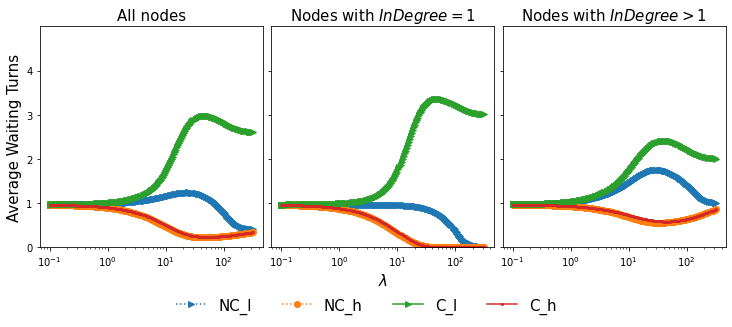

In [172]:
# Calculate the average waiting turns for each treatment, ndoes with 1 or multiple information 
turns = np.array([0,1,2,3,4,5])
QREs = [QRE_a_l, QRE_a_h, QRE_b_l, QRE_b_h]
TreatmentName = ['NC_l','NC_h', 'C_l', 'C_h']
Network = ['nc', 'nc', 'c','c']
Cost = ['l','h','l','h']

avg_turn = np.empty((4,n,5))
for t in range(4):
    for i in range(n):
        QRE = QREs[t]
        x = QRE[i]*turns
        avg_turn[t][i] = x.sum(axis=1)


fig, axes = plt.subplots(nrows=1, ncols=3,  sharex=True,  sharey=True,   constrained_layout=True, figsize=(10,4))
fig.set_constrained_layout_pads( w_pad=1 / 100)

linestyle = {'c':'-', 'nc':':'}
markerstyle = {'l': '>', 'h': 'o' }
y_max = 5
y_step = 1

# Defining custom 'xlim' and 'ylim' values.
# custom_xlim = (1, 11)
custom_ylim = (0, y_max)
# custom_xtick = np.arange(1,11,step=1)
custom_ytick = np.arange(0,y_max,step=y_step)
# custom_xticklabel = [1,5,10]

plt.setp(axes, yticks= custom_ytick, ylim=custom_ylim)

for t in range(4):
    
    if t==3:
        axes[0].plot(lambd,avg_turn[t].mean(axis=1), label=str(TreatmentName[t]),
               linestyle=linestyle[Network[t]], marker=markerstyle[Cost[t]],  markersize=2)
    else: 
        axes[0].plot(lambd,avg_turn[t].mean(axis=1), label=str(TreatmentName[t]),
               linestyle=linestyle[Network[t]], marker=markerstyle[Cost[t]])
    axes[0].set_title('All nodes', fontsize=15) 
    
    if t<=1:
        axes[1].plot(lambd,avg_turn[t, :, [0,3,4]].mean(axis=0), label=str(TreatmentName[t]),
               linestyle=linestyle[Network[t]], marker=markerstyle[Cost[t]])
    elif t==3:
        axes[1].plot(lambd,avg_turn[t, :, [2,3,4]].mean(axis=0), label=str(TreatmentName[t]),
               linestyle=linestyle[Network[t]], marker=markerstyle[Cost[t]], markersize=2)
    else : 
        axes[1].plot(lambd,avg_turn[t, :, [2,3,4]].mean(axis=0), label=str(TreatmentName[t]),
               linestyle=linestyle[Network[t]], marker=markerstyle[Cost[t]])
    axes[1].set_title('Nodes with $InDegree=1$', fontsize=15) 
    
    
    if t<=1:
        axes[2].plot(lambd,avg_turn[t, :, [1,2]].mean(axis=0), label=str(TreatmentName[t]),
               linestyle=linestyle[Network[t]], marker=markerstyle[Cost[t]])
    elif t==3:
        axes[2].plot(lambd,avg_turn[t, :, [0,1]].mean(axis=0), label=str(TreatmentName[t]),
               linestyle=linestyle[Network[t]], marker=markerstyle[Cost[t]], markersize=2)
    else : 
        axes[2].plot(lambd,avg_turn[t, :, [0,1]].mean(axis=0), label=str(TreatmentName[t]),
               linestyle=linestyle[Network[t]], marker=markerstyle[Cost[t]])

    axes[2].set_title('Nodes with $InDegree>1$', fontsize=15) 
    
    axes[1].set_xlabel('$\lambda$', fontsize=15)
    axes[0].set_ylabel('Average Waiting Turns', fontsize=15)
    axes[0].set_xscale('log')
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(.5,-0.05), loc="center" , ncol=4, frameon=False, prop={'size':15})
fig.savefig("..\\Output_Figures\\05-QRE-Calculation\\"+"QRE_Extensive_AvgTurns"  , bbox_inches="tight")  

